In [1]:

# The script is used to integrate data between monkey cortex and mouse cortex data
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(harmony))
suppressMessages(library(scrattch.hicat))
# suppressMessages(library(clusterProfiler))
# suppressMessages(library(GO.db))
# suppressMessages(library(biomaRt))
# suppressMessages(library(GSA))
suppressMessages(library(eulerr))
suppressMessages(library(enrichplot))
suppressMessages(library(clusterProfiler))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(scales))
library(class)



options(future.globals.maxSize=100*1024^3) # 100G memory

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

select_markers = function (norm.dat, cl, n.markers = 20, de.genes = NULL, ...) {
    if (is.null(de.genes)) {
        de.genes = de_stats_all_pairs(norm.dat, cl, ...)
    }
    pairs = names(de.genes)
    select.pairs = pairs
    de.markers = sapply(select.pairs, function(s) {
        tmp = de.genes[[s]]
        c(head(tmp$up.genes, n.markers), head(tmp$down.genes, 
            n.markers))
    }, simplify = F)
    markers = intersect(unlist(de.markers), row.names(norm.dat))
    return(list(markers = markers, de.genes = de.genes[select.pairs]))
}



In [2]:
#Amygdala 3和8改名字

In [3]:
outdir='/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/3area_compare_240123/compare_to_nearby/data'
integrateSeurat=readRDS(paste0(outdir, "/4area_compare_seurat_ALL_down300.rds"))


integrateSeurat@meta.data[grep('Insular',(integrateSeurat@meta.data$merge_anno)),]$group='Insular'
integrateSeurat@meta.data[grep('Clastrum',(integrateSeurat@meta.data$merge_anno)),]$group='Claustrum'
integrateSeurat@meta.data[grep('Amygdala',(integrateSeurat@meta.data$merge_anno)),]$group='Amygdala'
integrateSeurat@meta.data[grep('Putamen',(integrateSeurat@meta.data$merge_anno)),]$group='Putamen'

table(integrateSeurat$group)



 Amygdala Claustrum   Insular   Putamen 
    11939     14400     13800     12556 

In [4]:
sub1=subset(integrateSeurat, group %in% c("Claustrum","Putamen"))
sub2=subset(integrateSeurat, group %in% c("Claustrum","Insular"))
sub3=subset(integrateSeurat, group %in% c("Claustrum","Amygdala"))

cols=c(brewer.pal(4,"Set1"))
names(cols)=unique(integrateSeurat$group)


In [5]:
cols

Claustrum   Putamen   Insular  Amygdala 
"#E41A1C" "#377EB8" "#4DAF4A" "#984EA3"

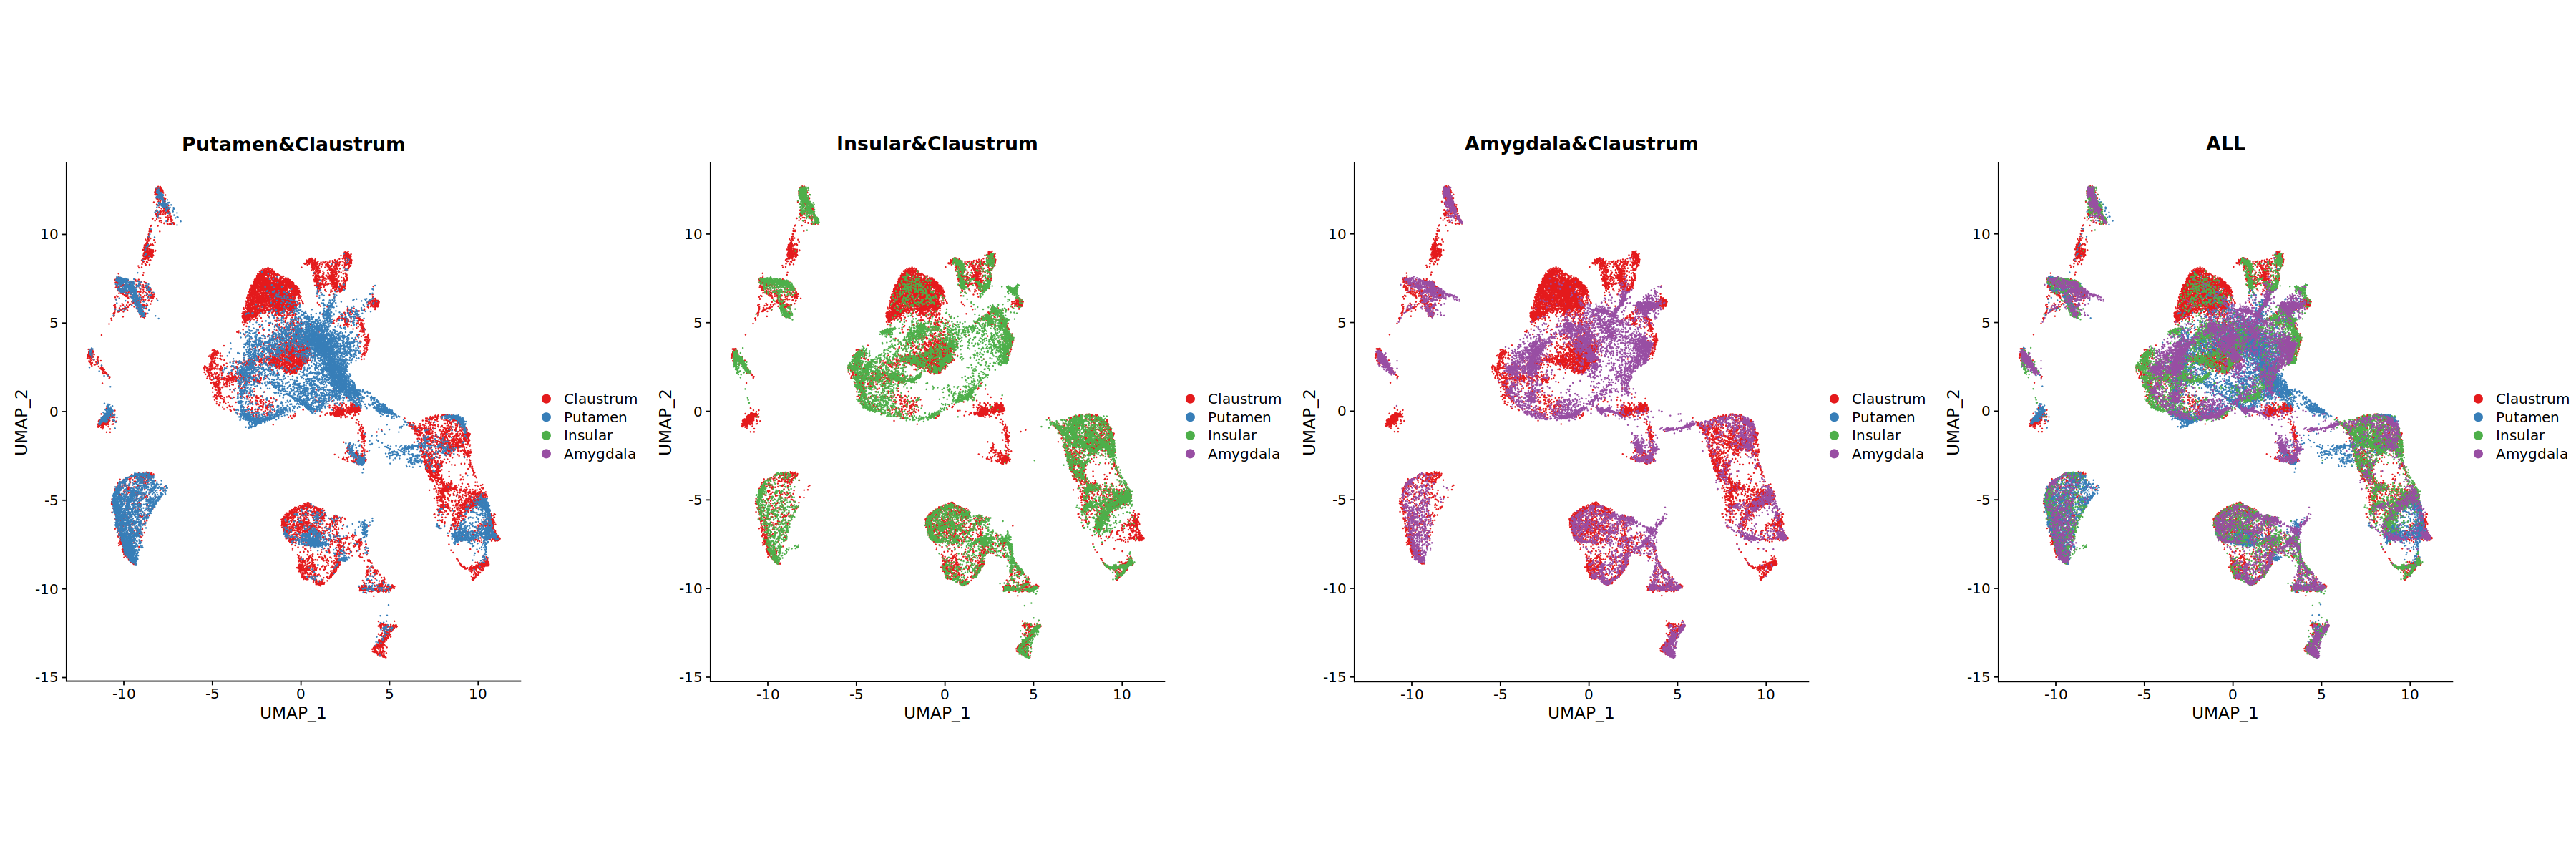

In [6]:
options(repr.plot.width=30, repr.plot.height=10)
gp=plot_grid(
    DimPlot(sub1, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Putamen&Claustrum"),
    DimPlot(sub2, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Insular&Claustrum"),
    DimPlot(sub3, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Amygdala&Claustrum"),
    DimPlot(integrateSeurat, reduction="umap", group.by="group",raster=FALSE,cols=cols)+coord_fixed()+ggtitle("ALL"),
    nrow=1
)   
gp


In [7]:
sub1=subset(integrateSeurat, group %in% c("Putamen"))
sub2=subset(integrateSeurat, group %in% c("Insular"))
sub3=subset(integrateSeurat, group %in% c("Amygdala"))
sub4=subset(integrateSeurat, group %in% c("Claustrum"))

cols=c(brewer.pal(4,"Set1"))
names(cols)=unique(integrateSeurat$group)



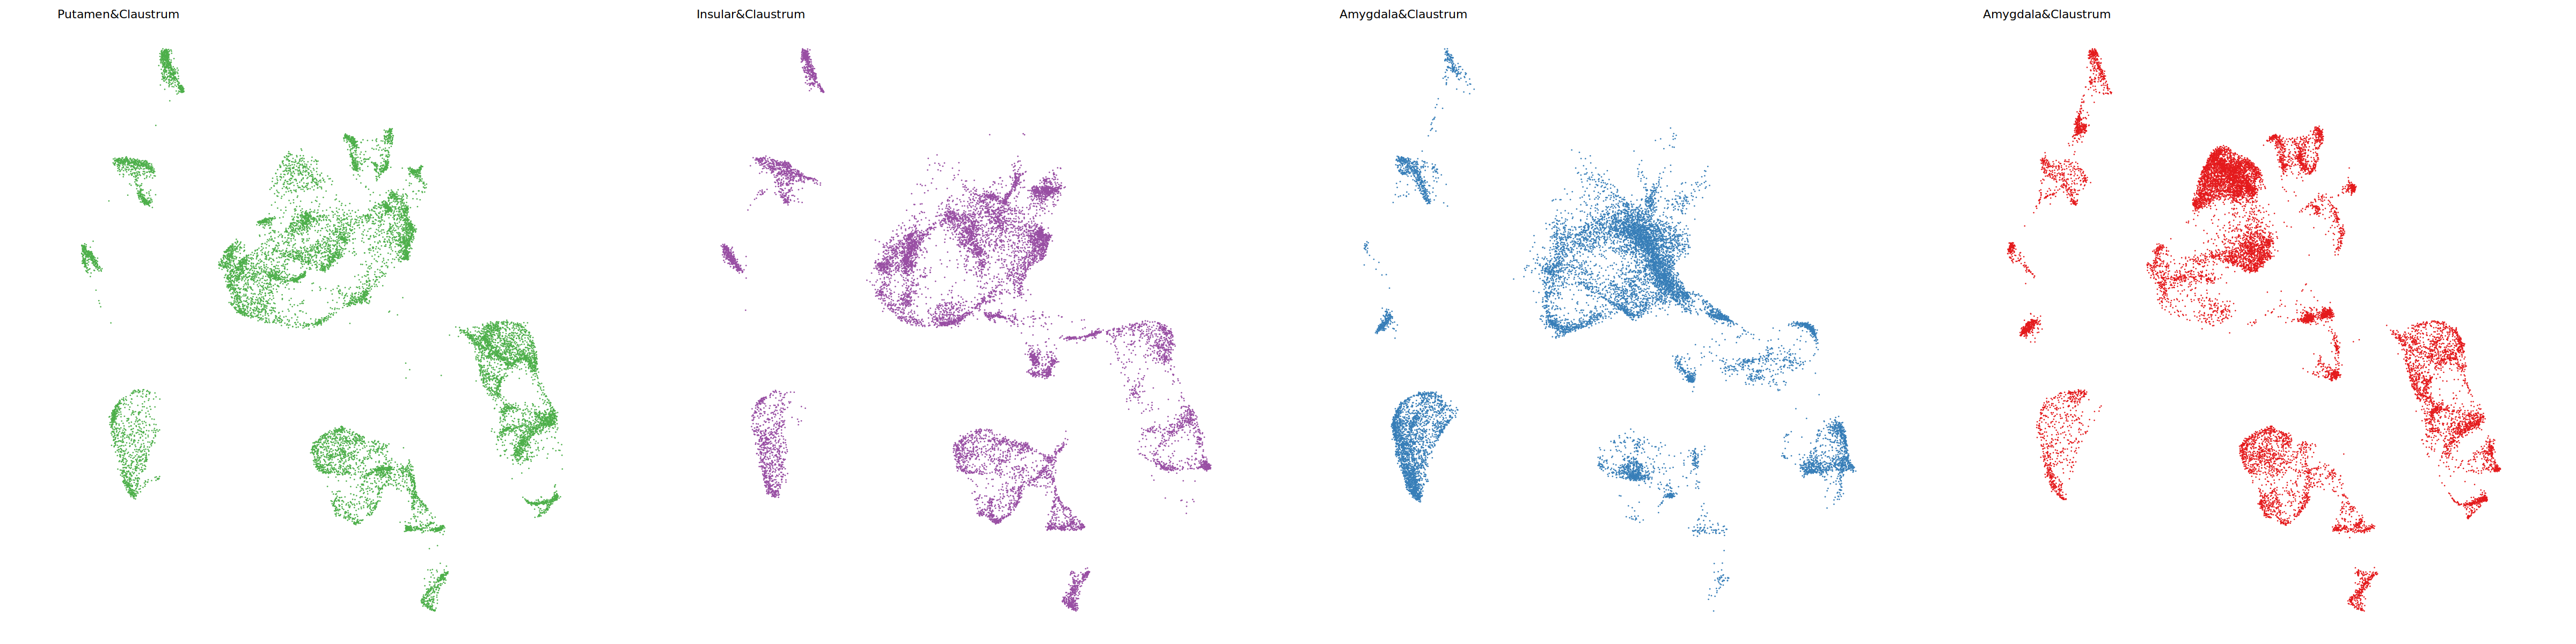

In [8]:
options(repr.plot.width=40, repr.plot.height=10)
gp=plot_grid(
    DimPlot(sub2, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Putamen&Claustrum")+theme_void()+NoLegend(),
    DimPlot(sub3, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Insular&Claustrum")+theme_void()+NoLegend(),
    DimPlot(sub1, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Amygdala&Claustrum")+theme_void()+NoLegend(),
    DimPlot(sub4, reduction="umap", group.by="group", label=F,raster=FALSE,cols=cols)+coord_fixed()+ggtitle("Amygdala&Claustrum")+theme_void()+NoLegend(),
    #DimPlot(integrateSeurat, reduction="umap", group.by="group",raster=FALSE,cols=cols)+coord_fixed()+ggtitle("ALL"),
    nrow=1
)   
gp


In [9]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/fig2_3.pdf", width=40, height=10)
gp
dev.off()

png 
  2

In [10]:
121.462+269.83+269.83

[1] 661.122

In [11]:
png("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/fig2_2.png", width=2000, height=700)
gp
dev.off()


png 
  2

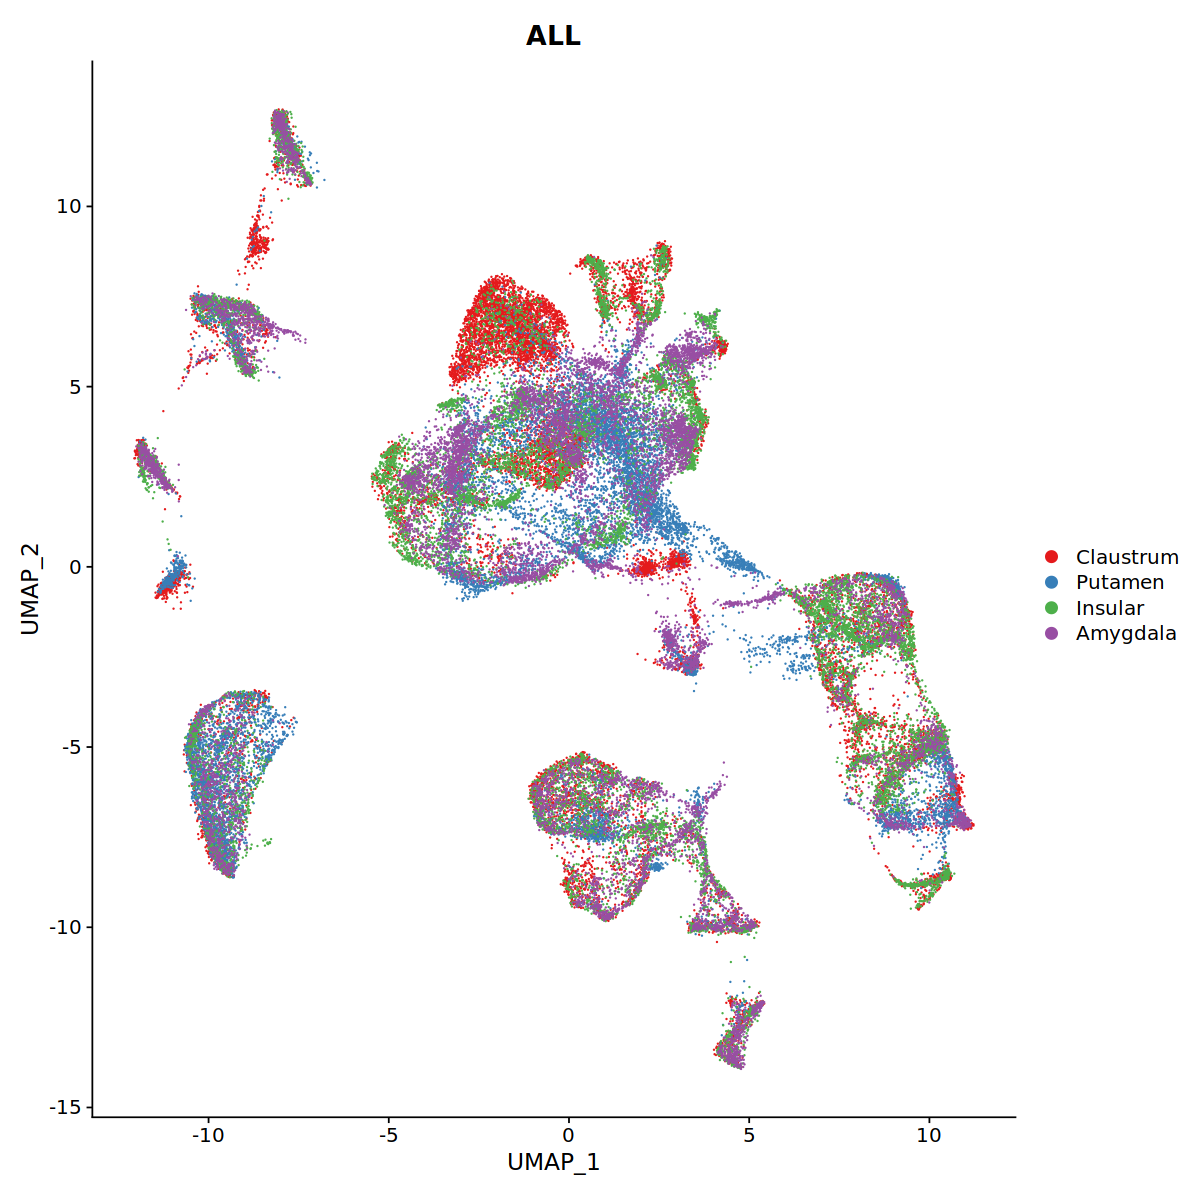

In [12]:
options(repr.plot.width=10, repr.plot.height=10)
gp=DimPlot(integrateSeurat, reduction="umap", group.by="group",raster=FALSE,cols=cols)+coord_fixed()+ggtitle("ALL")
gp

In [13]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/merge4.pdf", width=10, height=10)
gp
dev.off()


png 
  2

In [14]:
df_col=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_0105/post_analysis/data/color_supercluster_all_insu.csv')

col=df_col$col
names(col)=df_col$X
col

GLUT_GNB4-        GLUT_GNB4+         GLUT_VENO        GABA_PVALB 
        "#E41A1C"         "#377EB8"         "#4DAF4A"         "#984EA3" 
         GABA_SST        GABA_LAMP5   GABA_LAMP5_LHX6          GABA_VIP 
        "#FF7F00"         "#FFFF33"         "#A65628"         "#F781BF" 
        GABA_RELN          GABA_CHC             Oligo        Astrocytes 
        "#999999"         "#66C2A5"         "#FC8D62"         "#8DA0CB" 
        GABA_DRD2         Microglia               OPC        Endotheial 
        "#E78AC3"         "#A6D854"         "#FFD92F"         "#E5C494" 
       GLUT_L5 ET      GLUT_L2/3 IT GLUT_L5/6 IT Car3        GLUT_L5 IT 
        "#8DD3C7"         "#FFFFB3"         "#BEBADA"         "#FB8072" 
       GLUT_L6 IT        GLUT_L6 CT        GLUT_L4 IT          GLUT_L6b 
        "#80B1D3"         "#FDB462"         "#B3DE69"         "#FCCDE5" 
     GLUT_L5/6 NP 
        "#D9D9D9"

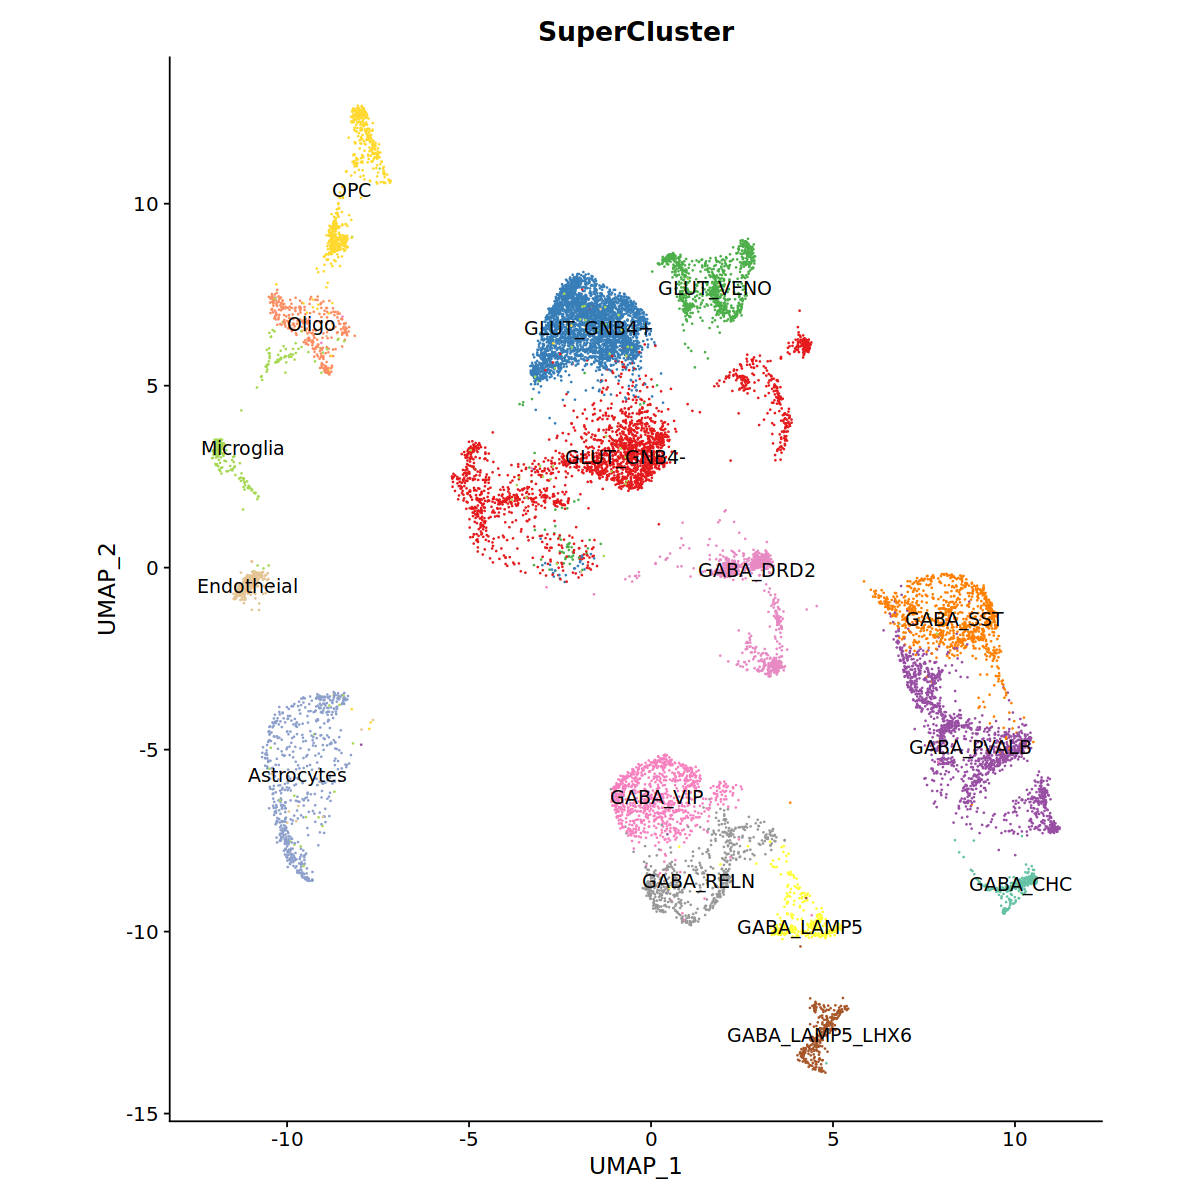

In [15]:
cla=subset(integrateSeurat,group=='Claustrum')
options(repr.plot.width=10, repr.plot.height=10)
p1=DimPlot(cla, reduction="umap",label=T,group.by = 'SuperCluster',raster=FALSE,cols = col)+coord_fixed()+NoLegend()
p1

In [16]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/umap_clastrum_super.pdf", width=10, height=10)
p1
dev.off()


png 
  2

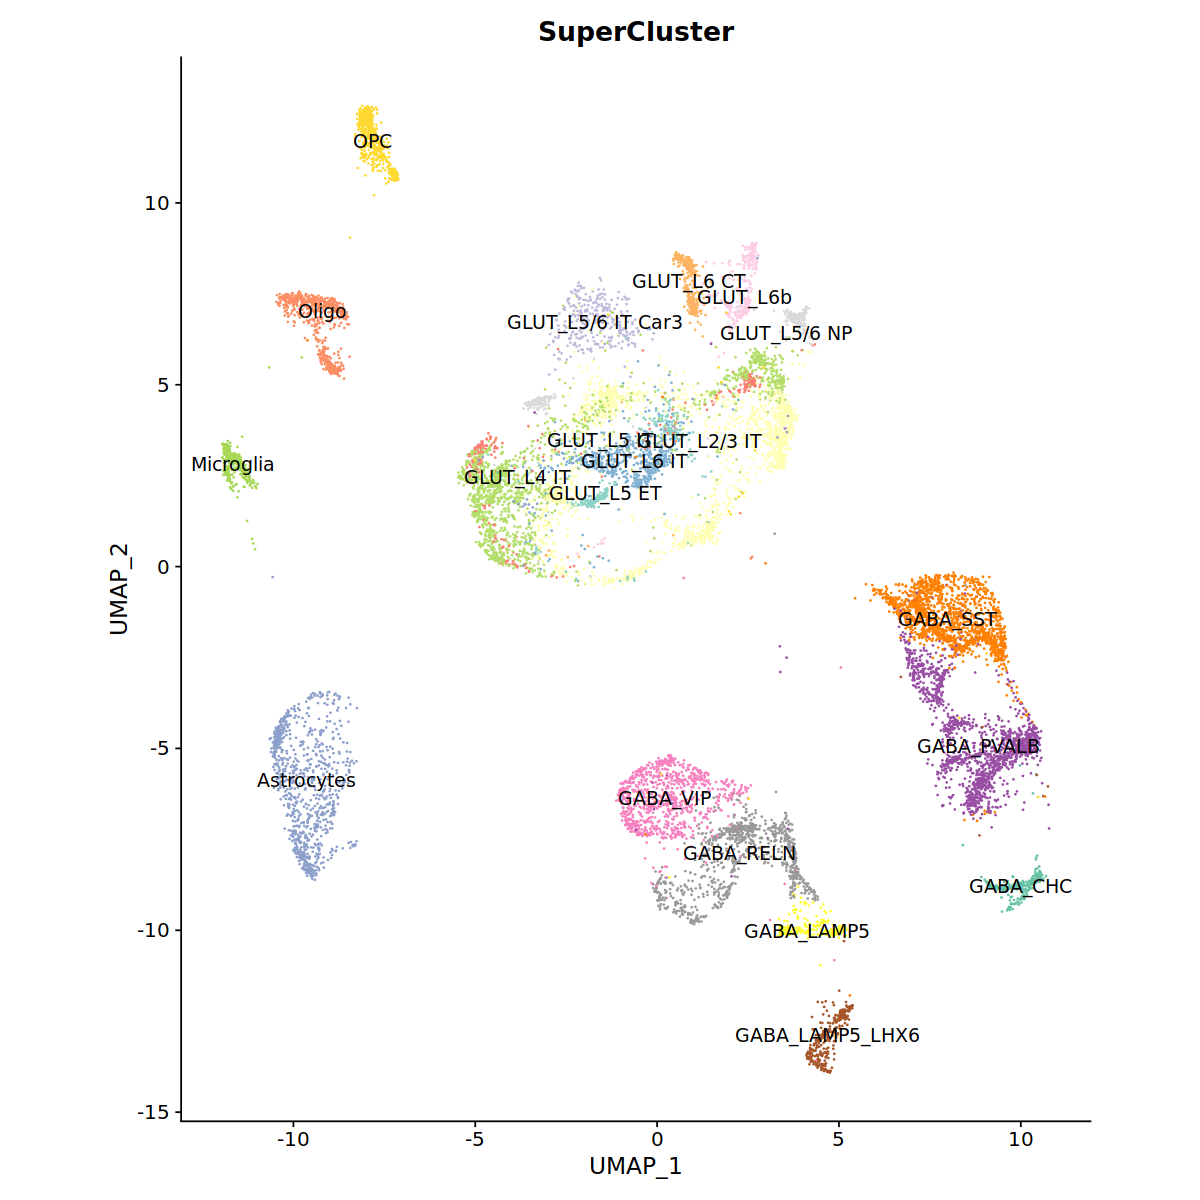

In [17]:
insu=subset(integrateSeurat,group=='Insular')
options(repr.plot.width=10, repr.plot.height=10)
p1=DimPlot(insu, reduction="umap",label=T,group.by = 'SuperCluster',raster=FALSE,cols = col)+coord_fixed()+NoLegend()
p1


In [18]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/umap_insula_super.pdf", width=10, height=10)
p1
dev.off()


png 
  2

In [17]:

reorder_matrix <- function(matrix1, by.rows = TRUE) {
  if (by.rows == TRUE) {
    conf.order <- order(apply(matrix1, 1, which.max))
    matrix1.reordered <- matrix1[conf.order, ]
  } else {
    conf.order <- order(apply(matrix1, 2, which.max))
    matrix1.reordered <- matrix1[, conf.order]
  }
}

compare_cl <- function(cl, ref.cl,
                       plot.title = NA, plot.silent = TRUE,
                       heat.colors = colorRampPalette(c("white", "grey70", "black"))(100),
                       row.cl.num = min(length(unique(cl)),
                                        length(unique(ref.cl)))) {
  library(grid)
  library(pheatmap)
  
  conf1 <- table(cl, ref.cl) # a count table with cl as row and ref.cl as column
  conf1 <- sweep(conf1, 1, rowSums(conf1), "/") # make the sum of each row = 1, the ratio of one cl related to each ref.cl
  conf2 <- reorder_matrix(conf1) # order the matrix to put high value to the diagonal
  
  # Cluster co-occurence
  cl.prop.cocl <- apply(conf1, 2, function(x) {
    grid1 <- expand.grid(x, x) # 一个完全展开的2列data.frame
    min.prop <- apply(grid1, 1, min)
  })
  
  cl.prop.cocl.total <- apply(cl.prop.cocl, 1, sum)
  cl.prop.cocl.m <- matrix(cl.prop.cocl.total, nrow(conf1), nrow(conf1),
                           dimnames = list(rownames(conf1), rownames(conf1)))
  # cl.prop.cocl.m 记录了cl中任意两类之间的共聚类的比例,取的是最小值之和,个人觉得这个计算方法很奇怪
  ph1 <- pheatmap(conf2, cutree_rows = row.cl.num, clustering_method = "ward.D2",
                  # annotation_row = ref.cl.anno[, -grep("cluster_label", colnames(ref.cl.anno))],
                  color = heat.colors, fontsize = 6,
                  main = plot.title, silent = plot.silent)
  return(list(conf = conf2, cocl = cl.prop.cocl.m, ph = ph1))
}

save_pheatmap_pdf <- function(x, filename, width=120, height=24) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

options(scipen=200)

In [18]:
integrateSeurat$clusterNameMod=gsub('__','-_',integrateSeurat$clusterNameMod)

cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)
cocl <- cl.conf$cocl

row_raw=rownames(cocl)
row_raw=gsub('Amygdala','Amy',row_raw)
row_raw=gsub('Clastrum','Cla',row_raw)
row_raw=gsub('Putamen','Pu',row_raw)
row_raw=gsub('Insular','Ins',row_raw)
row_raw=gsub('Microglia','MIC',row_raw)
row_raw=gsub('Astrocytes','AST',row_raw)
row_raw=gsub('Oligo','OLIG',row_raw)
row_raw=gsub('Endotheial','ENDO',row_raw)
rownames(cocl)=row_raw

col_raw=colnames(cocl)
col_raw=gsub('Amygdala','Amy',col_raw)
col_raw=gsub('Clastrum','Cla',col_raw)
col_raw=gsub('Putamen','Pu',col_raw)
col_raw=gsub('Insular','Ins',col_raw)
col_raw=gsub('Microglia','MIC',col_raw)
col_raw=gsub('Astrocytes','AST',col_raw)
col_raw=gsub('Oligo','OLIG',col_raw)
col_raw=gsub('Endotheial','ENDO',col_raw)
colnames(cocl)=col_raw


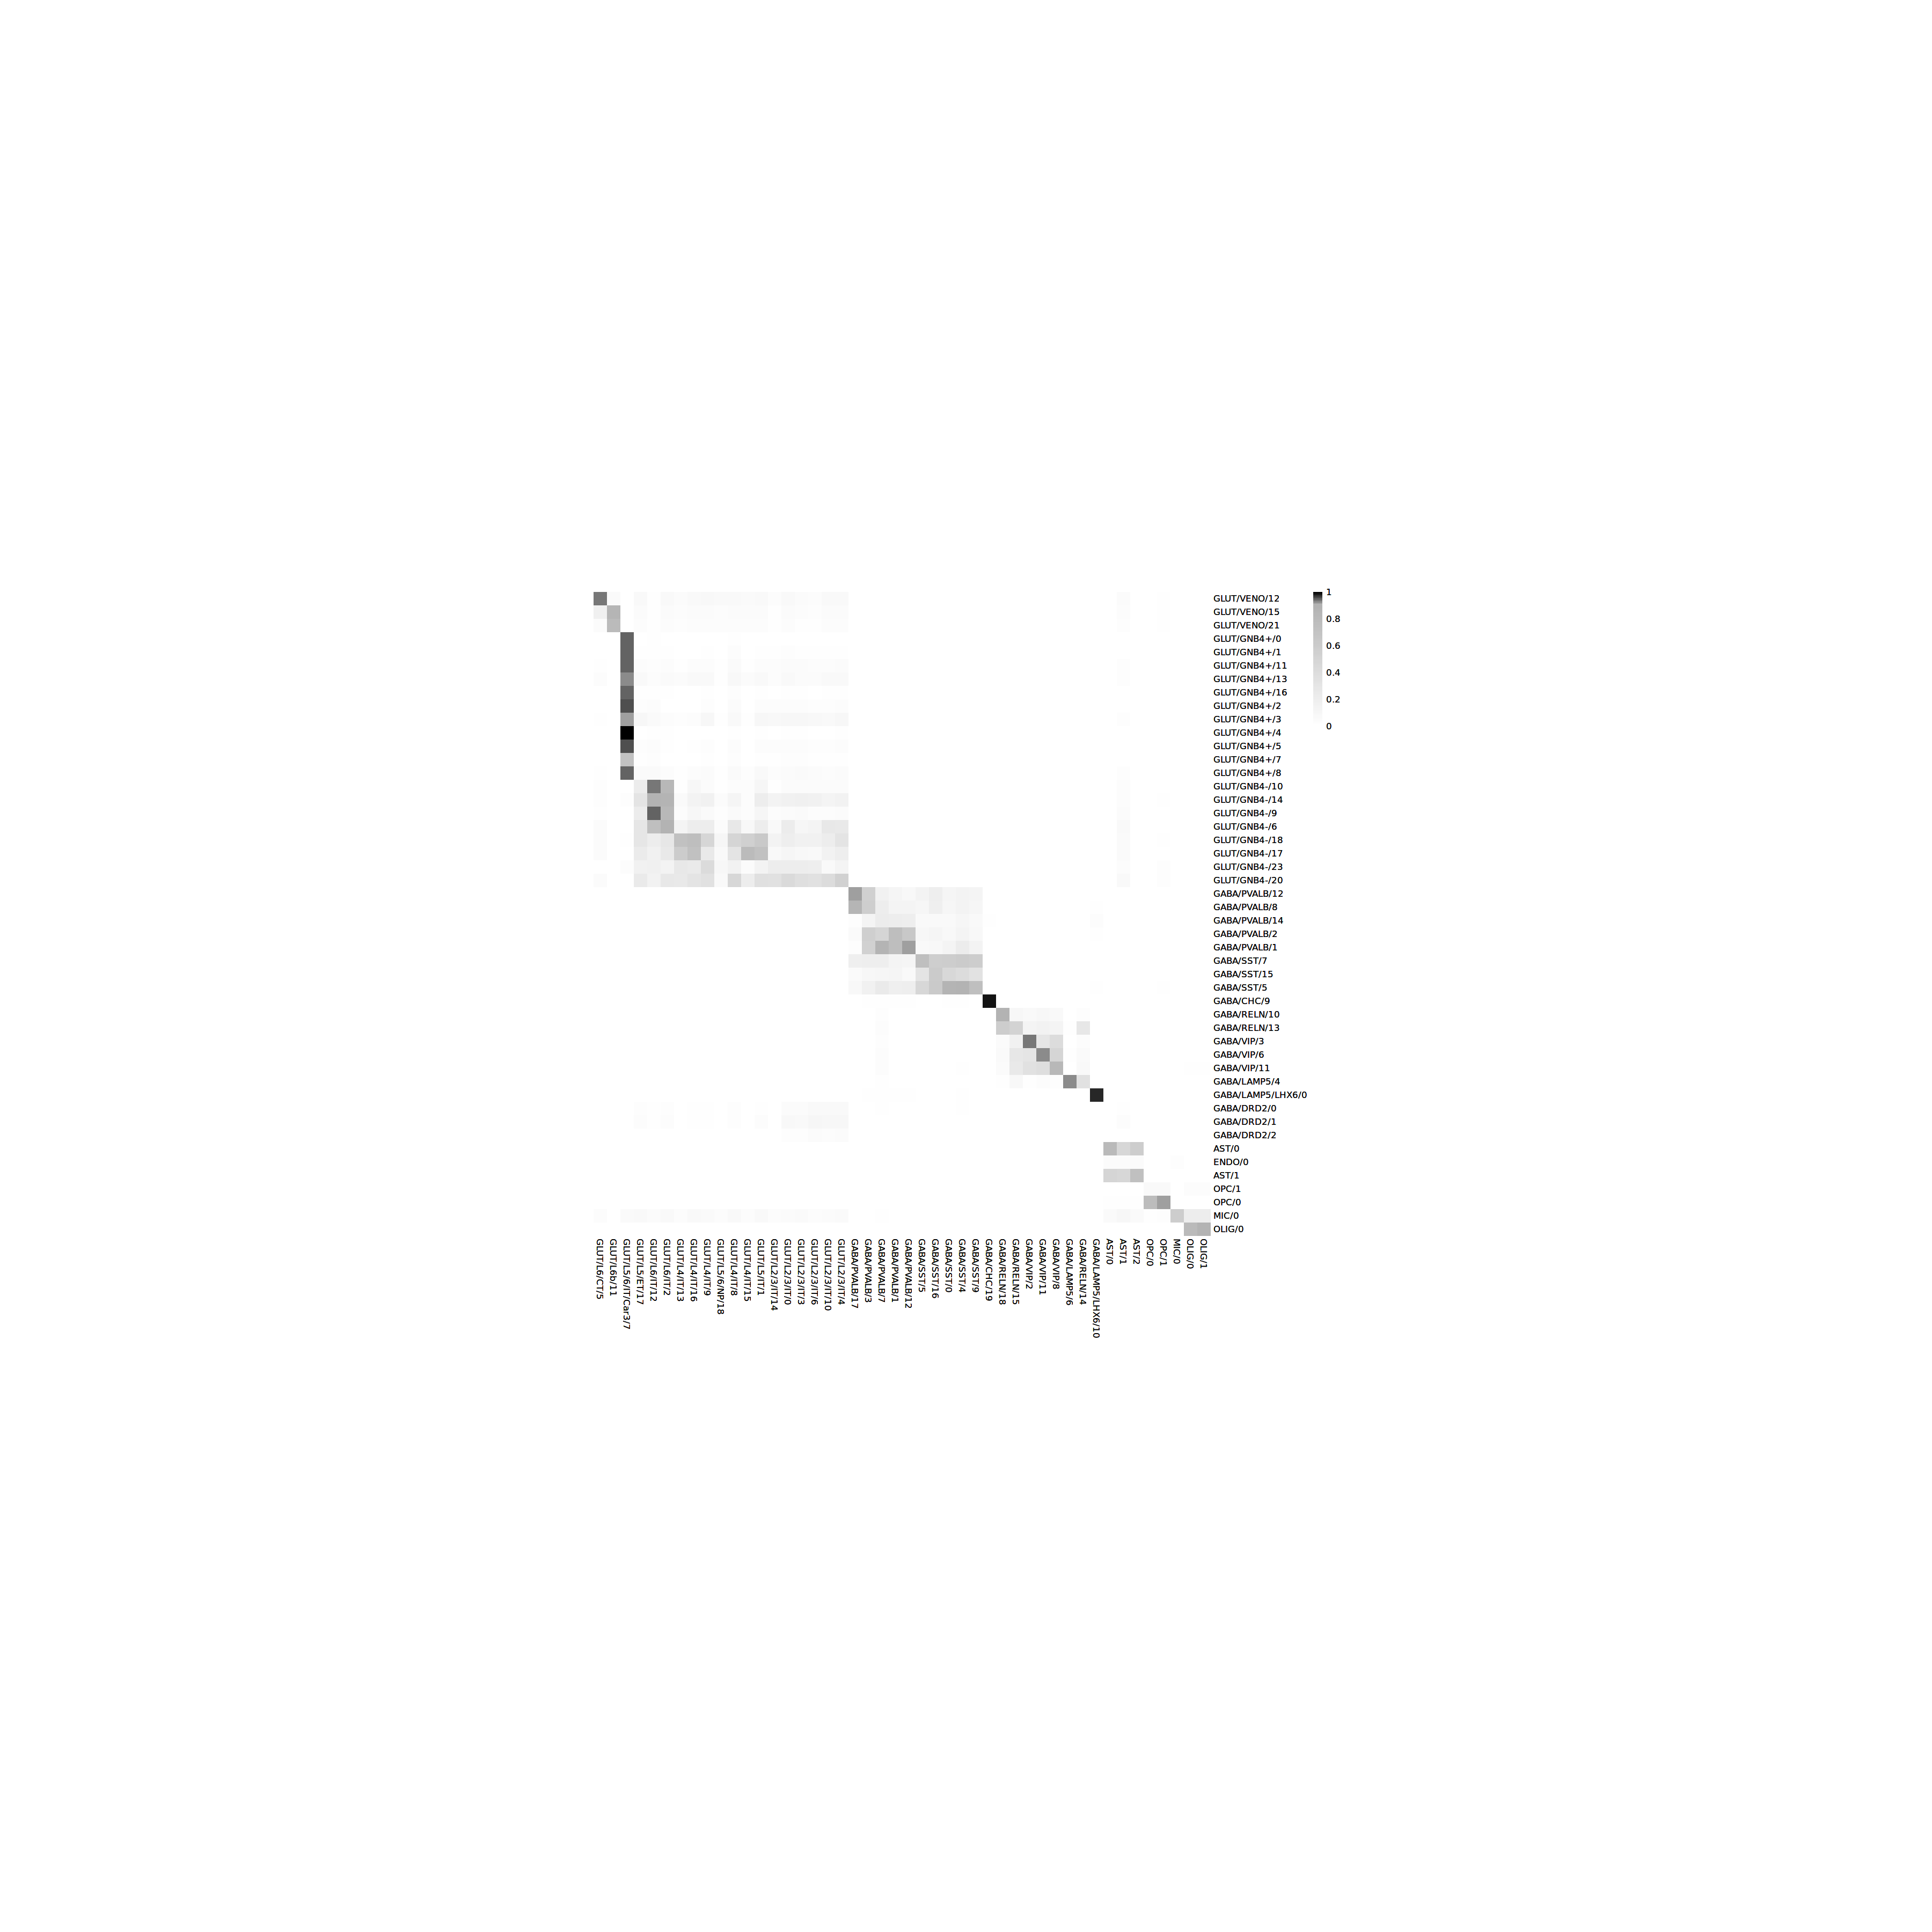

In [19]:


cocl.subset <- cocl[grepl("Cla", row.names(cocl)),
                    grepl("Ins", row.names(cocl))]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=T)
all_n=rownames(cocl.subset)
ex_n=all_n[grep('GLUT',all_n)]
ex_n1=ex_n[grep('VENO',ex_n)]
ex_n2=setdiff(ex_n,ex_n1)
ex_n=c(ex_n1,ex_n2)

in_n=all_n[grep('GABA',all_n)]
non_n1=in_n[grep('PV',in_n)]
non_n2=in_n[grep('SST',in_n)]
non_n3=in_n[grep('CHC',in_n)]
non_n4=in_n[grep('RELN',in_n)]
non_n5=in_n[grep('VIP',in_n)]
non_n6=in_n[grep('LAMP',in_n)]
non_n7=in_n[grep('DRD',in_n)]
in_n=c(non_n1,non_n2,non_n3,non_n4,non_n5,non_n6,non_n7)

non_n=setdiff(all_n,c(ex_n,in_n))

cocl.subset1=cocl.subset[c(ex_n,in_n,non_n),]


cocl.subset1 = reorder_matrix(cocl.subset1, by.rows=F)

options(repr.plot.width=30, repr.plot.height=30)

heat.colors <- c(colorRampPalette(c("white", "grey70"))(90), colorRampPalette(c("grey70", "black"))(10))
df1=cocl.subset1

rownames(cocl.subset1)=gsub('Cla_','',rownames(cocl.subset1))
rownames(cocl.subset1)=gsub('Ins_','',rownames(cocl.subset1))
colnames(cocl.subset1)=gsub('Cla_','',colnames(cocl.subset1))
colnames(cocl.subset1)=gsub('Ins_','',colnames(cocl.subset1))



rownames(cocl.subset1)=gsub('_','/',rownames(cocl.subset1))
colnames(cocl.subset1)=gsub('_','/',colnames(cocl.subset1))
gp1=pheatmap(cocl.subset1, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp1


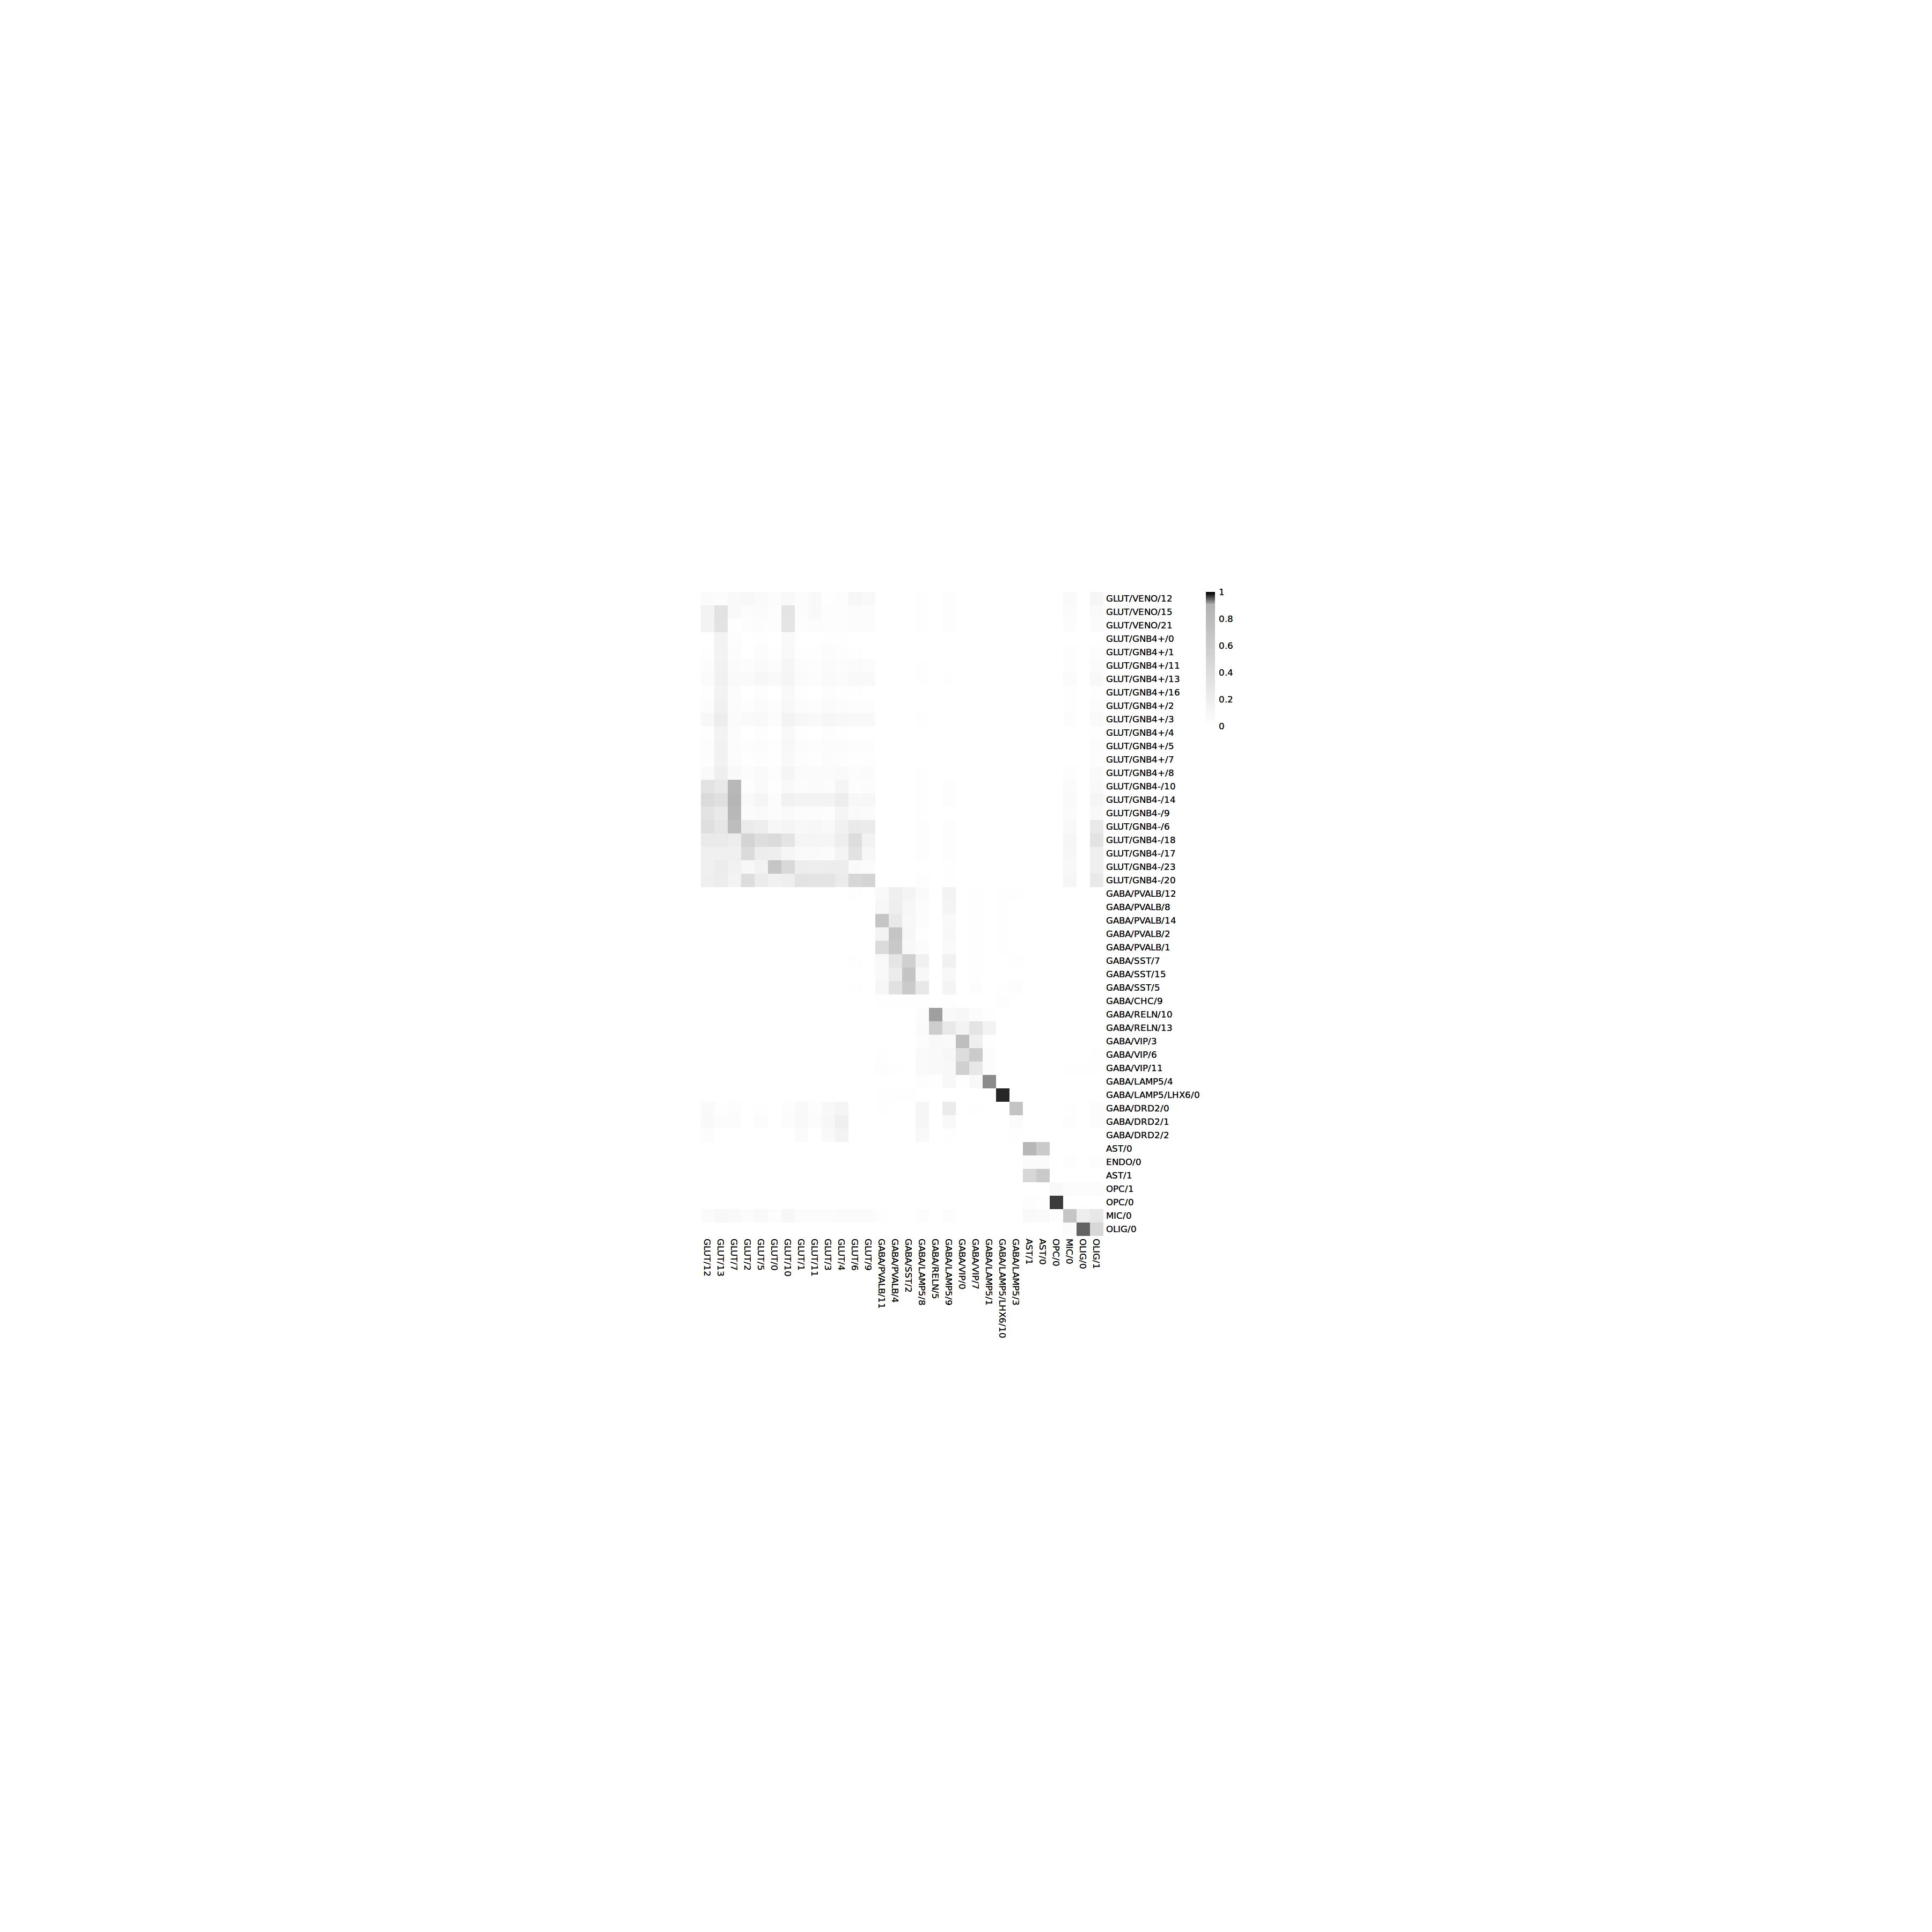

In [20]:

cocl.subset <- cocl[grepl("Cla", row.names(cocl)),
                    grepl("Amy", row.names(cocl))]

cocl.subset = cocl.subset[rownames(df1), ]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
options(repr.plot.width=30, repr.plot.height=30)

heat.colors <- c(colorRampPalette(c("white", "grey70"))(90), colorRampPalette(c("grey70", "black"))(10))
df2=cocl.subset
rownames(cocl.subset)=gsub('Cla_','',rownames(cocl.subset))
rownames(cocl.subset)=gsub('Amy_','',rownames(cocl.subset))
colnames(cocl.subset)=gsub('Cla_','',colnames(cocl.subset))
colnames(cocl.subset)=gsub('Amy_','',colnames(cocl.subset))


rownames(cocl.subset)=gsub('_','/',rownames(cocl.subset))
colnames(cocl.subset)=gsub('_','/',colnames(cocl.subset))

gp2=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp2


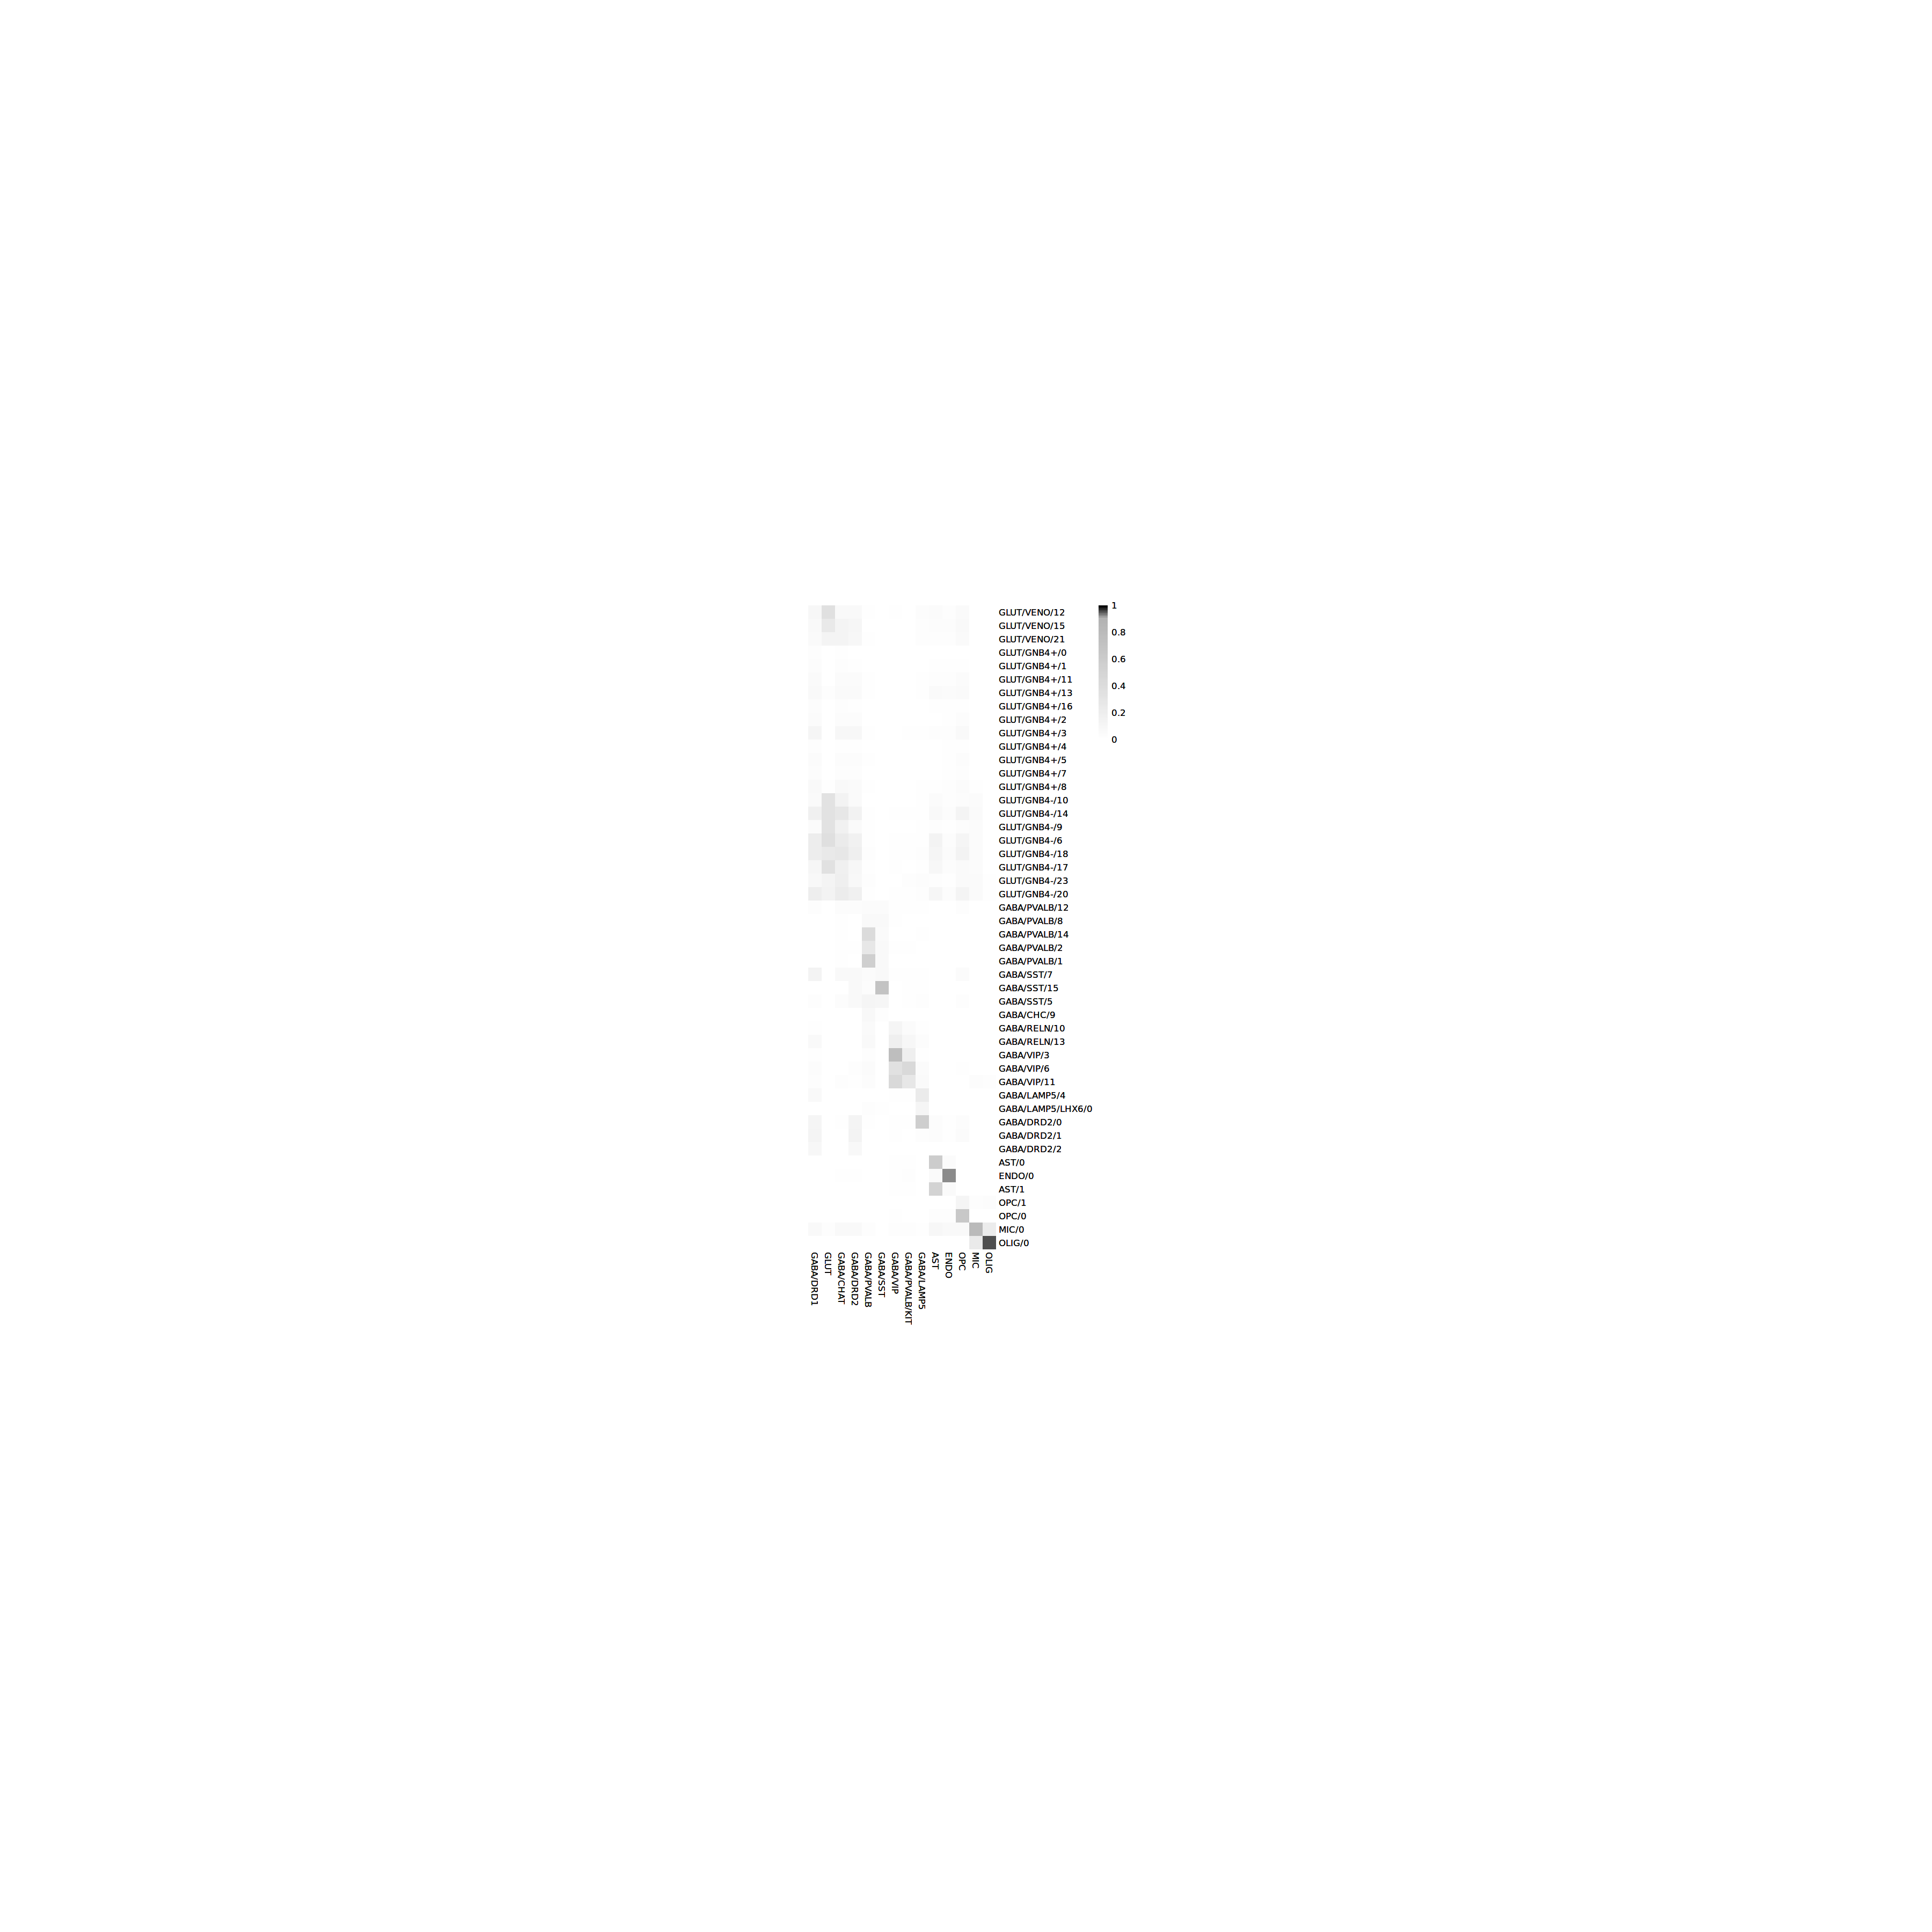

In [21]:

cocl.subset <- cocl[grepl("Cla", row.names(cocl)),
                    grepl("Pu", row.names(cocl))]

cocl.subset = cocl.subset[rownames(df1), ]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
options(repr.plot.width=30, repr.plot.height=30)

heat.colors <- c(colorRampPalette(c("white", "grey70"))(90), colorRampPalette(c("grey70", "black"))(10))
df3=cocl.subset

rownames(cocl.subset)=gsub('Cla_','',rownames(cocl.subset))
rownames(cocl.subset)=gsub('Pu_','',rownames(cocl.subset))
colnames(cocl.subset)=gsub('Cla_','',colnames(cocl.subset))
colnames(cocl.subset)=gsub('Pu_','',colnames(cocl.subset))

rownames(cocl.subset)=gsub('_','/',rownames(cocl.subset))
colnames(cocl.subset)=gsub('_','/',colnames(cocl.subset))

gp3=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp3




In [22]:
save_pheatmap_pdf <- function(x, filename, width=15, height=15) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}



save_pheatmap_pdf(gp1,"/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat1.pdf",20,20)
save_pheatmap_pdf(gp2,"/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat2.pdf",20,20)
save_pheatmap_pdf(gp3,"//home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat3.pdf",20,20)


png 
  2

png 
  2

png 
  2

In [58]:
df_clastrum_insular=melt(df1)
df_clastrum_putamen=melt(df3)
df_clastrum_amygdala=melt(df2)

colnames(df_clastrum_insular)=c('clastrum','insular','clastrum_insular')
colnames(df_clastrum_putamen)=c('clastrum','putamen','clastrum_putamen')
colnames(df_clastrum_amygdala)=c('clastrum','amygdala','clastrum_amygdala')

#head(df_clastrum_putamen)
#head(df_clastrum_insular)

#选取与clastrum对照打分最高的
df_com_insular=df_clastrum_insular %>% group_by(clastrum) %>% summarise(insular_clastrum_max=max(clastrum_insular))
colnames(df_com_insular)[2]='clastrum_insular'
df_com_insular=left_join(df_com_insular,df_clastrum_insular)
#head(df_com_insular)

#选取与clastrum对照打分最高的
df_com_putamen=df_clastrum_putamen %>% group_by(clastrum) %>% summarise(putamen_clastrum_max=max(clastrum_putamen))
colnames(df_com_putamen)[2]='clastrum_putamen'
df_com_putamen=left_join(df_com_putamen,df_clastrum_putamen)
#head(df_com_putamen)

#选取与clastrum对照打分最高的
df_com_amygdala=df_clastrum_amygdala %>% group_by(clastrum) %>% summarise(amygdala_clastrum_max=max(clastrum_amygdala))
colnames(df_com_amygdala)[2]='clastrum_amygdala'
df_com_amygdala=left_join(df_com_amygdala,df_clastrum_amygdala)
#head(df_com_amygdala)
clastrum_all_select_type=as.character(unique(df_com_amygdala$clastrum))
df_com_amygdala_new=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[i],][1,]
    df_com_amygdala_new=rbind(df_com_amygdala_new,aba)
}


#renew！！！
clastrum_all_select_type=as.character(unique(df_com_insular$clastrum))
df_com_insular_new=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[i],][1,]
    df_com_insular_new=rbind(df_com_insular_new,aba)
}

clastrum_all_select_type=as.character(unique(df_com_putamen$clastrum))
df_com_putamen_new=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[i],][1,]
    df_com_putamen_new=rbind(df_com_putamen_new,aba)
}

all_n=df_com_insular_new$clastrum
ex_n=all_n[grep("GLUT",all_n)]
ex_n=as.character(ex_n)
in_n=all_n[grep("GABA",all_n)]
in_n=as.character(in_n)
non_n=setdiff(all_n,c(ex_n,in_n))
non_n=as.character(non_n)

df_com_insular_new$cla_class='test'
df_com_insular_new[df_com_insular_new$clastrum %in% ex_n,]$cla_class='GLUT'
df_com_insular_new[df_com_insular_new$clastrum %in% in_n,]$cla_class='GABA'
df_com_insular_new[df_com_insular_new$clastrum %in% non_n,]$cla_class='Non-Neuron'

df_com_putamen_new$cla_class='test'
df_com_putamen_new[df_com_putamen_new$clastrum %in% ex_n,]$cla_class='GLUT'
df_com_putamen_new[df_com_putamen_new$clastrum %in% in_n,]$cla_class='GABA'
df_com_putamen_new[df_com_putamen_new$clastrum %in% non_n,]$cla_class='Non-Neuron'


df_putamen=df_com_putamen_new[,c('clastrum_putamen','cla_class')]
colnames(df_putamen)=c('ratio','class')
df_putamen$type='puteman'

df_com_amygdala_new$cla_class='test'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% ex_n,]$cla_class='GLUT'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% in_n,]$cla_class='GABA'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% non_n,]$cla_class='Non-Neuron'


df_amygdala=df_com_amygdala_new[,c('clastrum_amygdala','cla_class')]
colnames(df_amygdala)=c('ratio','class')
df_amygdala$type='amygdala'

df_insular=df_com_insular_new[,c('clastrum_insular','cla_class')]
colnames(df_insular)=c('ratio','class')
df_insular$type='insular'

df_all=rbind(rbind(df_putamen,df_insular),df_amygdala)


options(repr.plot.width=7, repr.plot.height=3)



#df_all_fil=data.frame(table(df_all$clastrum_layer))
#sel_layer=as.character(df_all_fil[df_all_fil$Freq>=10,]$Var1)
#df_all=df_all[df_all$clastrum_layer %in% sel_layer,]

#df_all$clastrum_layer=factor(df_all$clastrum_layer,levels = c('Upper-layer intratelencephalic','Deep-layer intratelencephalic',
#                         'Deep-layer near-projecting','Deep-layer corticothalamic and 6b'))



Joining, by = c("clastrum", "clastrum_insular")
Joining, by = c("clastrum", "clastrum_putamen")
Joining, by = c("clastrum", "clastrum_amygdala")


In [59]:
mean(df_all[df_all$class=='GABA' & df_all$type=='puteman',]$ratio)
mean(df_all[df_all$class=='GABA' & df_all$type=='amygdala',]$ratio)


[1] 0.2911948

[1] 0.5579312

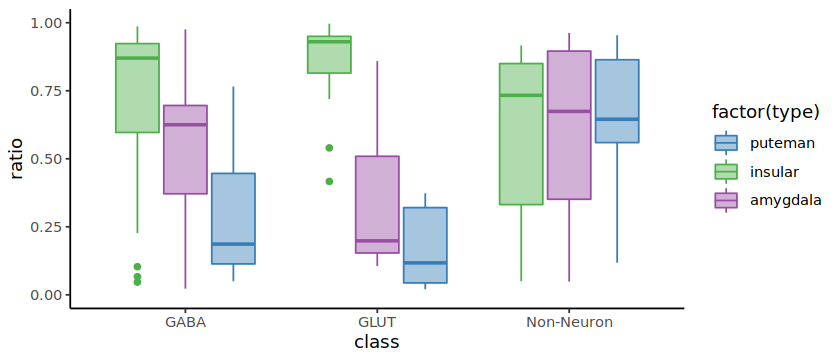

In [60]:
df_all$type=factor(df_all$type,levels=c('insular','amygdala','puteman'))

col_pal=c('#377EB8','#4DAF4A','#984EA3')
names(col_pal)=c('puteman','insular','amygdala')

col_pal_fill=c('#A6C5DF','#AFDBAE','#D1B0D6')
names(col_pal_fill)=c('puteman','insular','amygdala')

gp1=ggplot(df_all, aes(x = class, y = ratio, fill = factor(type),color=factor(type))) +  geom_boxplot()+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()+coord_cartesian(ylim = c(0, 1))
gp1

In [61]:
library(ggpubr)


In [62]:
unique(df_all$class)

[1] "GLUT"       "GABA"       "Non-Neuron"

In [63]:
df_all1=df_all[df_all$class=='GLUT',]
compare_means(ratio~type, data=df_all1)  
df_all1=df_all[df_all$class=='GABA',]
compare_means(ratio~type, data=df_all1)  
df_all1=df_all[df_all$class=='Non-Neuron',]
compare_means(ratio~type, data=df_all1)  

.y.   group1   group2   p                p.adj       p.format    p.signif
1 ratio insular  amygdala 0.00000047242502 0.000000940 0.000000472 ****    
2 ratio insular  puteman  0.00000001417696 0.000000043 0.000000014 ****    
3 ratio amygdala puteman  0.00948918708463 0.009500000 0.0095      **      
  method  
1 Wilcoxon
2 Wilcoxon
3 Wilcoxon

.y.   group1   group2   p            p.adj  p.format p.signif method  
1 ratio insular  amygdala 0.0616832125 0.0620 0.06168  ns       Wilcoxon
2 ratio insular  puteman  0.0006159169 0.0018 0.00062  ***      Wilcoxon
3 ratio amygdala puteman  0.0046251278 0.0093 0.00463  **       Wilcoxon

.y.   group1   group2   p         p.adj p.format p.signif method  
1 ratio insular  amygdala 0.9015152 1     0.90     ns       Wilcoxon
2 ratio insular  puteman  0.7103730 1     0.71     ns       Wilcoxon
3 ratio amygdala puteman  1.0000000 1     1.00     ns       Wilcoxon

In [68]:
(189.976-181.344)*2+189.976

[1] 207.24

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message in wilcox.test.default(c(0.933333333333333, 0.87, 0.796666666666667, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.105833333333333, 0.334166666666667, 0.326666666666667, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.363333333333333,

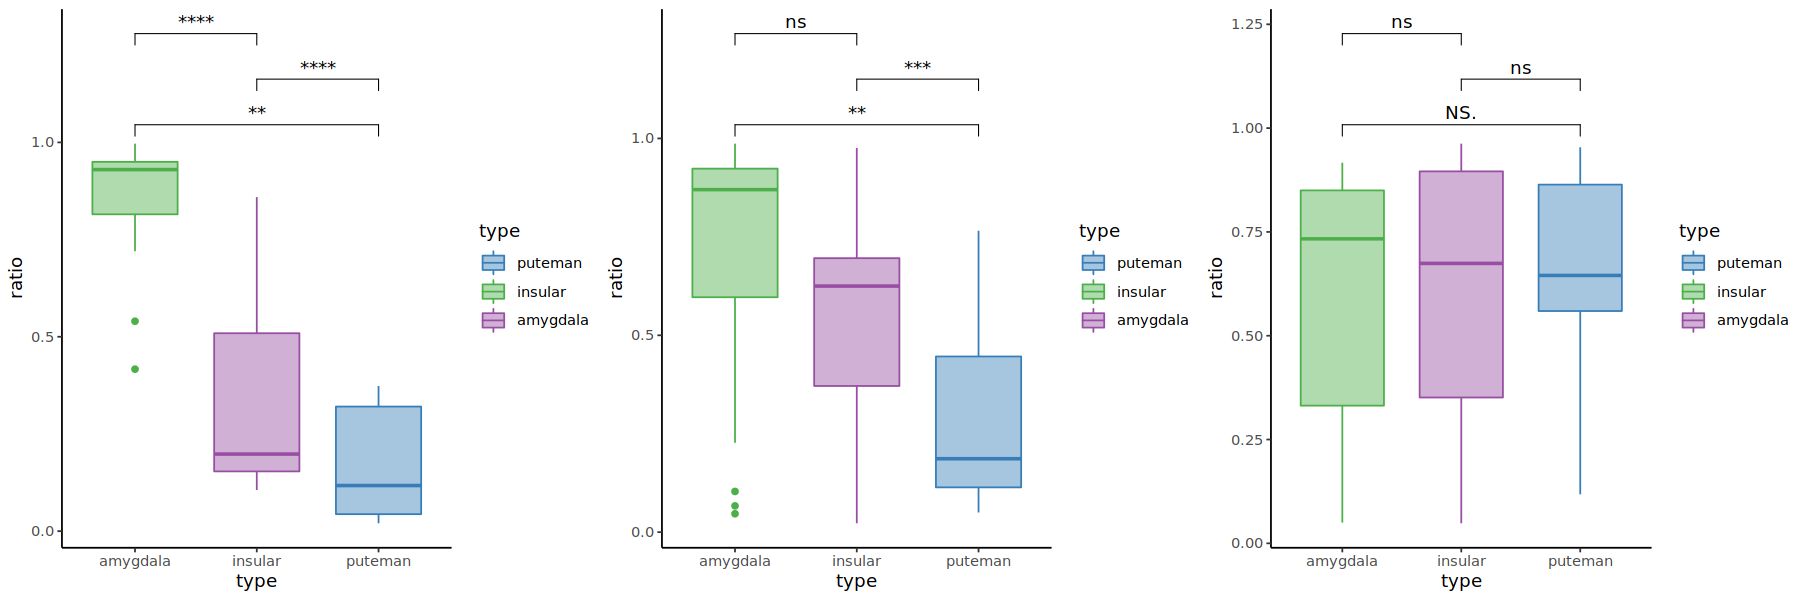

In [46]:
options(repr.plot.width=5, repr.plot.height=5)
df_all1$type=as.character(df_all1$type)
df_all1=df_all[df_all$class=='GLUT',]
my_comparisons <- list(c("amygdala", "puteman"), c("puteman", "insular"), c("insular", "amygdala"))
p1=ggboxplot(df_all1, x="type", y="ratio", palette = "jco",color = "type",fill="type")+
stat_compare_means(comparisons=my_comparisons,label = "p.signif",)+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()
df_all1=df_all[df_all$class=='GABA',]
p2=ggboxplot(df_all1, x="type", y="ratio", palette = "jco",color = "type",fill="type")+
stat_compare_means(comparisons=my_comparisons,label = "p.signif",)+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()
df_all1=df_all[df_all$class=='Non-Neuron',]
p3=ggboxplot(df_all1, x="type", y="ratio", palette = "jco",color = "type",fill="type")+
stat_compare_means(comparisons=my_comparisons,label = "p.signif",)+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()
options(repr.plot.width=15, repr.plot.height=5)
gp1=plot_grid(p1,p2,p3,nrow=1)
gp1

In [ ]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat_sort_ALL.pdf", width=15, height=5)
gp1
dev.off()

In [127]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat_sort_ALL.pdf", width=7, height=3)
gp1
dev.off()

png 
  2

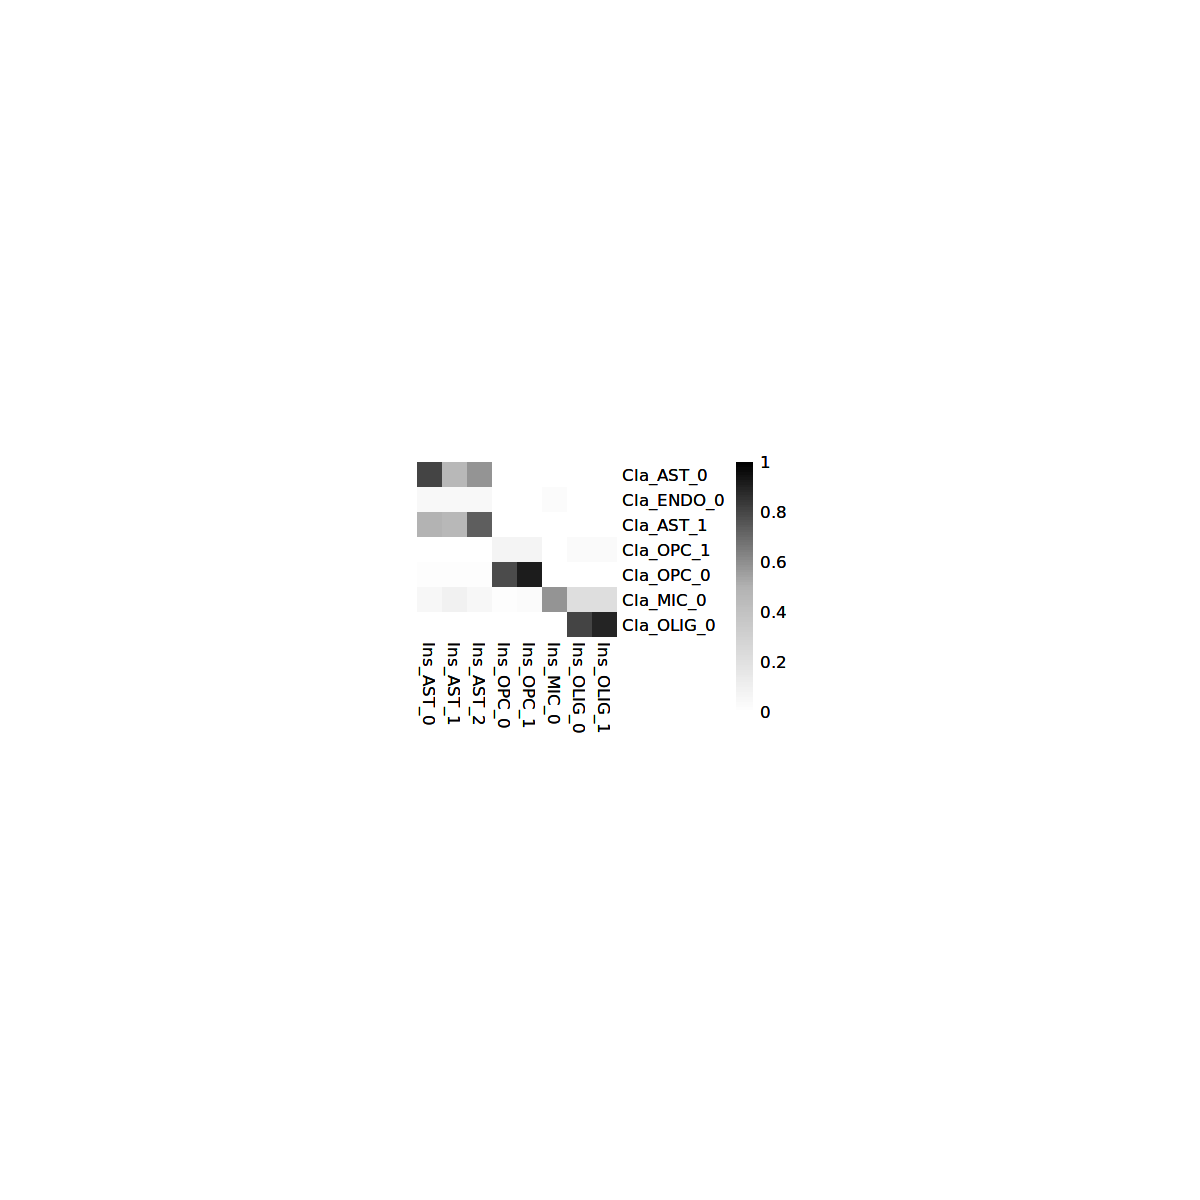

In [138]:
cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)
cocl <- cl.conf$cocl

row_raw=rownames(cocl)
row_raw=gsub('Amygdala','Amy',row_raw)
row_raw=gsub('Clastrum','Cla',row_raw)
row_raw=gsub('Putamen','Pu',row_raw)
row_raw=gsub('Insular','Ins',row_raw)
row_raw=gsub('Microglia','MIC',row_raw)
row_raw=gsub('Astrocytes','AST',row_raw)
row_raw=gsub('Oligo','OLIG',row_raw)
row_raw=gsub('Endotheial','ENDO',row_raw)
rownames(cocl)=row_raw

col_raw=colnames(cocl)
col_raw=gsub('Amygdala','Amy',col_raw)
col_raw=gsub('Clastrum','Cla',col_raw)
col_raw=gsub('Putamen','Pu',col_raw)
col_raw=gsub('Insular','Ins',col_raw)
col_raw=gsub('Microglia','MIC',col_raw)
col_raw=gsub('Astrocytes','AST',col_raw)
col_raw=gsub('Oligo','OLIG',col_raw)
col_raw=gsub('Endotheial','ENDO',col_raw)
colnames(cocl)=col_raw


cla_n=rownames(cocl)
ex_n=cla_n[grep('GLUT',cla_n)]
msn_n=cla_n[grep('MSN',cla_n)]
in_n=cla_n[grep('GABA',cla_n)]
cla_non_n=setdiff(cla_n,c(ex_n,in_n,msn_n))


ins_n=colnames(cocl)
ex_n=ins_n[grep('GLUT',ins_n)]
in_n=ins_n[grep('GABA',ins_n)]
in_non_n=setdiff(ins_n,c(ex_n,in_n))

cocl=cocl[cla_non_n,in_non_n]

cocl.subset <- cocl[row.names(cocl)[grepl("Cla", row.names(cocl))],
                    colnames(cocl)[grep("Ins", colnames(cocl))]]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=T)
sortedMacaqueCluster = rownames(cocl.subset)
options(repr.plot.width=10, repr.plot.height=10)

#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))
order_row=rownames(cocl.subset)
heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df1=cocl.subset
gp1=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15)
gp1


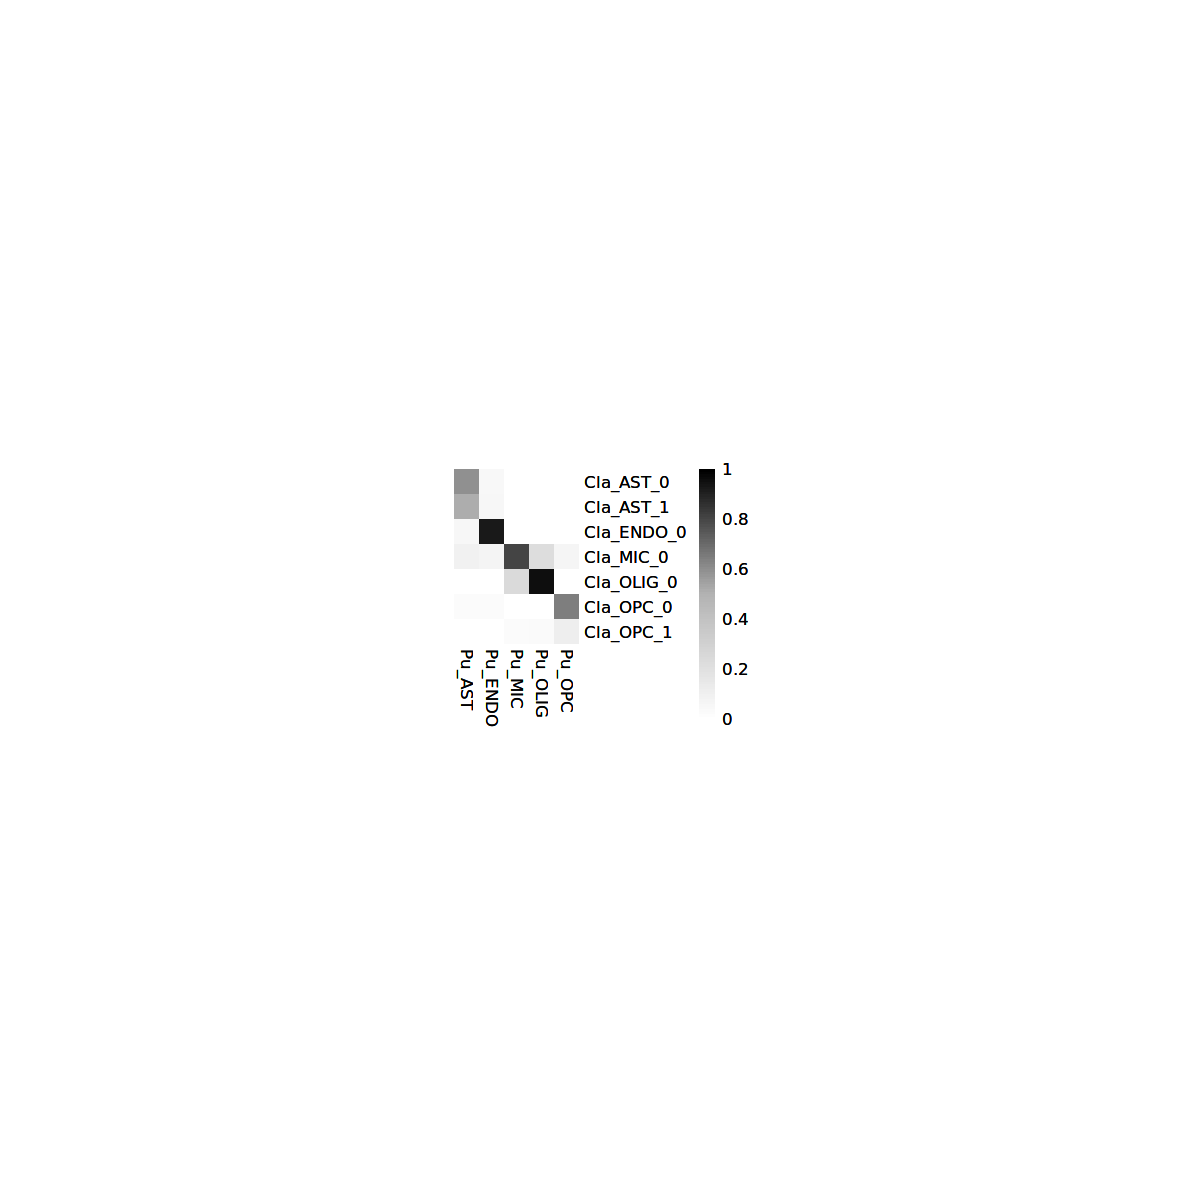

In [139]:
cocl.subset <- cocl[row.names(cocl)[grepl("Cla", row.names(cocl))],
                    colnames(cocl)[grep("Pu", colnames(cocl))]]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
sortedMacaqueCluster = rownames(cocl.subset)
options(repr.plot.width=10, repr.plot.height=10)

#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))
order_row=rownames(cocl.subset)
heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df2=cocl.subset
gp1=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15)
gp1


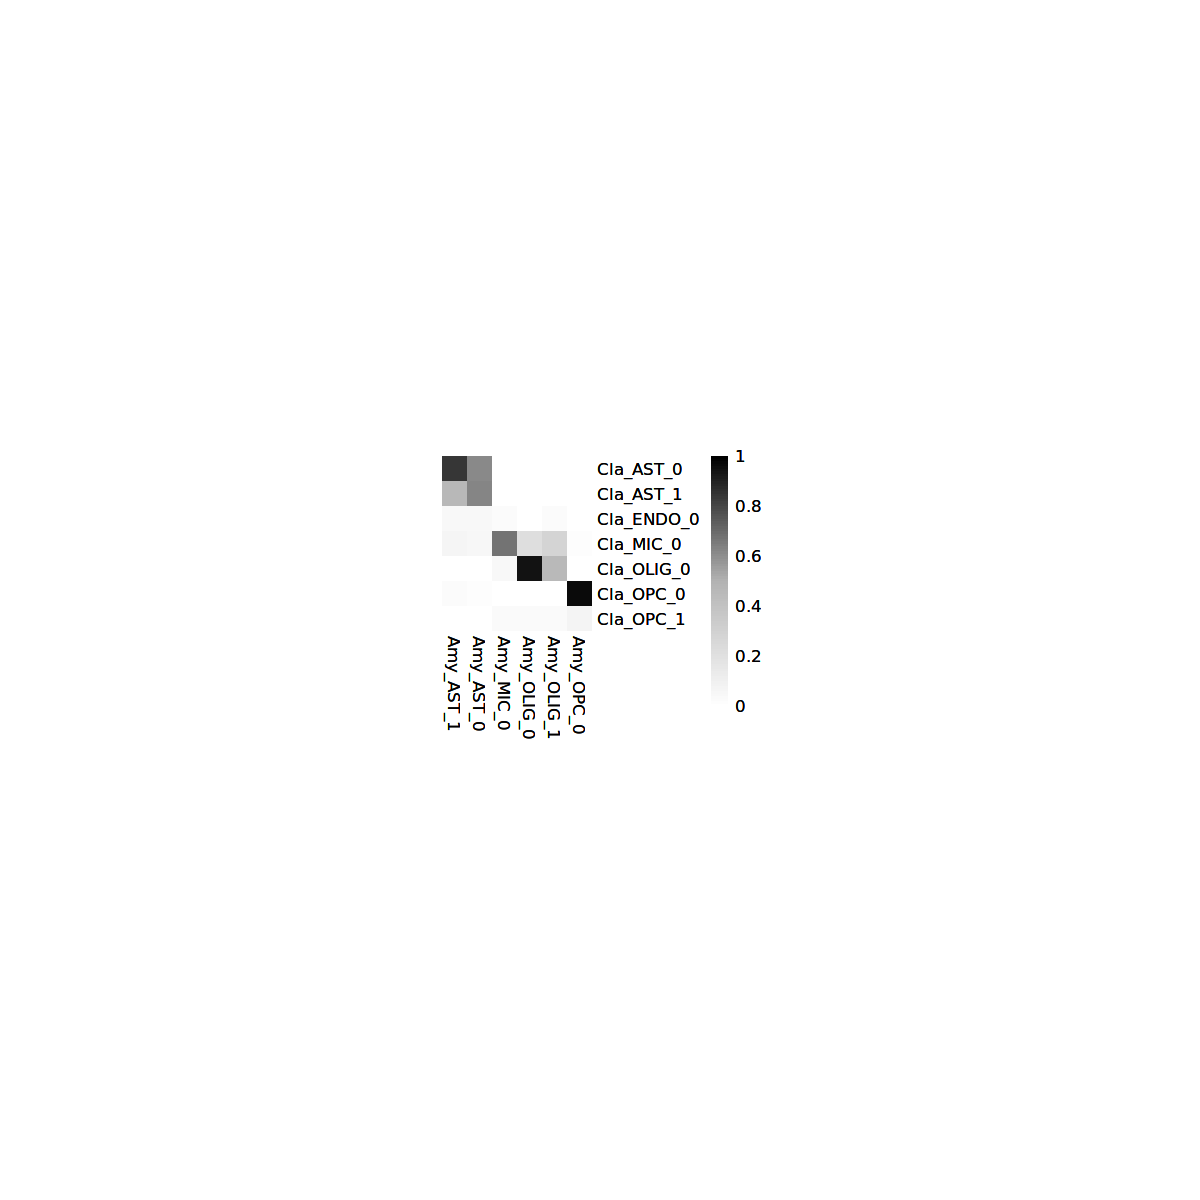

In [140]:
cocl.subset <- cocl[row.names(cocl)[grepl("Cla", row.names(cocl))],
                    colnames(cocl)[grep("Amy", colnames(cocl))]]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
sortedMacaqueCluster = rownames(cocl.subset)
options(repr.plot.width=10, repr.plot.height=10)

#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))
order_row=rownames(cocl.subset)
heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df3=cocl.subset
gp1=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15)
gp1


Joining, by = c("clastrum", "clastrum_insular")
Joining, by = c("clastrum", "clastrum_putamen")
Joining, by = c("clastrum", "clastrum_amygdala")


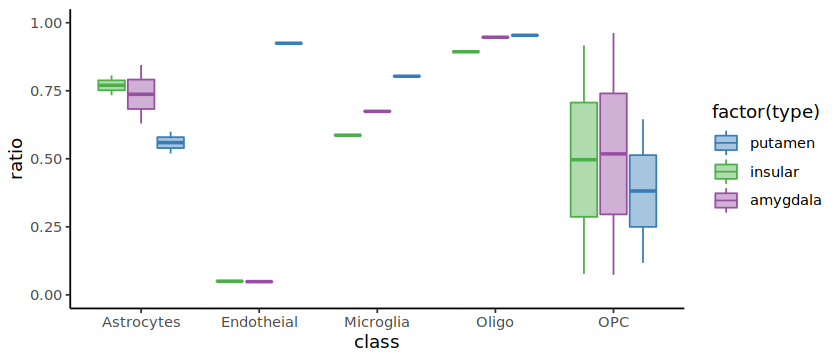

In [141]:
df_clastrum_insular=melt(df1)
df_clastrum_putamen=melt(df2)
df_clastrum_amygdala=melt(df3)

colnames(df_clastrum_insular)=c('clastrum','insular','clastrum_insular')
colnames(df_clastrum_putamen)=c('clastrum','putamen','clastrum_putamen')
colnames(df_clastrum_amygdala)=c('clastrum','amygdala','clastrum_amygdala')

#head(df_clastrum_putamen)
#head(df_clastrum_insular)

#选取与clastrum对照打分最高的
df_com_insular=df_clastrum_insular %>% group_by(clastrum) %>% summarise(insular_clastrum_max=max(clastrum_insular))
colnames(df_com_insular)[2]='clastrum_insular'
df_com_insular=left_join(df_com_insular,df_clastrum_insular)
#head(df_com_insular)

#选取与clastrum对照打分最高的
df_com_putamen=df_clastrum_putamen %>% group_by(clastrum) %>% summarise(putamen_clastrum_max=max(clastrum_putamen))
colnames(df_com_putamen)[2]='clastrum_putamen'
df_com_putamen=left_join(df_com_putamen,df_clastrum_putamen)
#head(df_com_putamen)

#选取与clastrum对照打分最高的
df_com_amygdala=df_clastrum_amygdala %>% group_by(clastrum) %>% summarise(amygdala_clastrum_max=max(clastrum_amygdala))
colnames(df_com_amygdala)[2]='clastrum_amygdala'
df_com_amygdala=left_join(df_com_amygdala,df_clastrum_amygdala)
#head(df_com_amygdala)
clastrum_all_select_type=as.character(unique(df_com_amygdala$clastrum))
df_com_amygdala_new=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[i],][1,]
    df_com_amygdala_new=rbind(df_com_amygdala_new,aba)
}


#renew！！！
clastrum_all_select_type=as.character(unique(df_com_insular$clastrum))
df_com_insular_new=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[i],][1,]
    df_com_insular_new=rbind(df_com_insular_new,aba)
}

clastrum_all_select_type=as.character(unique(df_com_putamen$clastrum))
df_com_putamen_new=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[i],][1,]
    df_com_putamen_new=rbind(df_com_putamen_new,aba)
}

all_n=df_com_insular_new$clastrum
LAMP5=all_n[grep("AST",all_n)]
LAMP5=as.character(LAMP5)
RELN=all_n[grep("ENDO",all_n)]
RELN=as.character(RELN)
VIP=all_n[grep("MIC",all_n)]
VIP=as.character(VIP)
SST=all_n[grep("OLIG",all_n)]
SST=as.character(SST)
PVALB=all_n[grep("OPC",all_n)]
PVALB=as.character(PVALB)

df_com_insular_new$cla_class='test'
df_com_insular_new[df_com_insular_new$clastrum %in% LAMP5,]$cla_class='Astrocytes'
df_com_insular_new[df_com_insular_new$clastrum %in% RELN,]$cla_class='Endotheial'
df_com_insular_new[df_com_insular_new$clastrum %in% VIP,]$cla_class='Microglia'
df_com_insular_new[df_com_insular_new$clastrum %in% SST,]$cla_class='Oligo'
df_com_insular_new[df_com_insular_new$clastrum %in% PVALB,]$cla_class='OPC'


df_com_putamen_new$cla_class='test'
df_com_putamen_new[df_com_putamen_new$clastrum %in% LAMP5,]$cla_class='Astrocytes'
df_com_putamen_new[df_com_putamen_new$clastrum %in% RELN,]$cla_class='Endotheial'
df_com_putamen_new[df_com_putamen_new$clastrum %in% VIP,]$cla_class='Microglia'
df_com_putamen_new[df_com_putamen_new$clastrum %in% SST,]$cla_class='Oligo'
df_com_putamen_new[df_com_putamen_new$clastrum %in% PVALB,]$cla_class='OPC'


df_com_putamen_new$cla_class='test'
df_com_putamen_new[df_com_putamen_new$clastrum %in% LAMP5,]$cla_class='Astrocytes'
df_com_putamen_new[df_com_putamen_new$clastrum %in% RELN,]$cla_class='Endotheial'
df_com_putamen_new[df_com_putamen_new$clastrum %in% VIP,]$cla_class='Microglia'
df_com_putamen_new[df_com_putamen_new$clastrum %in% SST,]$cla_class='Oligo'
df_com_putamen_new[df_com_putamen_new$clastrum %in% PVALB,]$cla_class='OPC'

df_com_amygdala_new$cla_class='test'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% LAMP5,]$cla_class='Astrocytes'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% RELN,]$cla_class='Endotheial'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% VIP,]$cla_class='Microglia'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% SST,]$cla_class='Oligo'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% PVALB,]$cla_class='OPC'


df_amygdala=df_com_amygdala_new[,c('clastrum_amygdala','cla_class')]
colnames(df_amygdala)=c('ratio','class')
df_amygdala$type='amygdala'

df_putamen=df_com_putamen_new[,c('clastrum_putamen','cla_class')]
colnames(df_putamen)=c('ratio','class')
df_putamen$type='putamen'
df_insular=df_com_insular_new[,c('clastrum_insular','cla_class')]
colnames(df_insular)=c('ratio','class')
df_insular$type='insular'
df_all=rbind(rbind(df_putamen,df_insular),df_amygdala)


options(repr.plot.width=7, repr.plot.height=3)

df_all$type=factor(df_all$type,levels=c('insular','amygdala','putamen'))

col_pal=c('#377EB8','#4DAF4A','#984EA3')
names(col_pal)=c('putamen','insular','amygdala')

col_pal_fill=c('#A6C5DF','#AFDBAE','#D1B0D6')
names(col_pal_fill)=c('putamen','insular','amygdala')

#df_all_fil=data.frame(table(df_all$clastrum_layer))
#sel_layer=as.character(df_all_fil[df_all_fil$Freq>=10,]$Var1)
#df_all=df_all[df_all$clastrum_layer %in% sel_layer,]

#df_all$clastrum_layer=factor(df_all$clastrum_layer,levels = c('Upper-layer intratelencephalic','Deep-layer intratelencephalic',
#                         'Deep-layer near-projecting','Deep-layer corticothalamic and 6b'))

#df_all=df_all[df_all$class != 'test',]

gp1=ggplot(df_all, aes(x = class, y = ratio, fill = factor(type),color=factor(type))) +  geom_boxplot()+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()+coord_cartesian(ylim = c(0, 1))
gp1




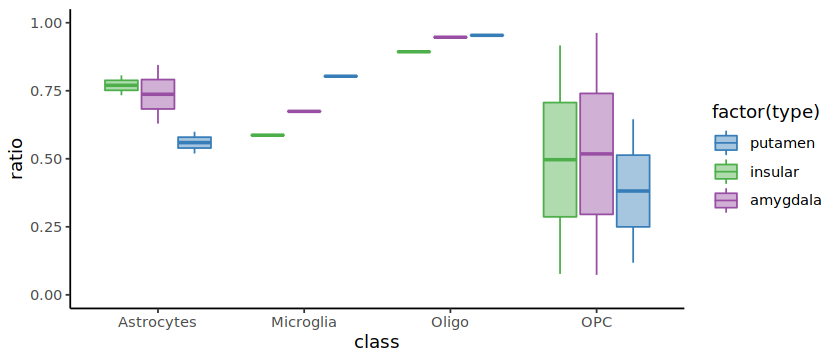

In [142]:
df_all=df_all[df_all$class %in% setdiff(unique(df_all$class),'Endotheial'),]
gp1=ggplot(df_all, aes(x = class, y = ratio, fill = factor(type),color=factor(type))) +  geom_boxplot()+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()+coord_cartesian(ylim = c(0, 1))
gp1



In [143]:
unique(df_all$type)

[1] putamen  insular  amygdala
Levels: insular amygdala putamen

In [145]:
options(repr.plot.width=5, repr.plot.height=15)
my_comparisons <- list(c(unique(df_all$type)[1], unique(df_all$type)[2]),
                       c(unique(df_all$type)[3], unique(df_all$type)[2]),
                       c(unique(df_all$type)[1], unique(df_all$type)[3]))


df_all1=df_all[df_all$class==unique(df_all$class)[1],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[2],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[3],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[4],]
compare_means(ratio~type, data=df_all1)  



.y.   group1   group2   p         p.adj p.format p.signif method  
1 ratio insular  amygdala 1.0000000 1     1.00     ns       Wilcoxon
2 ratio insular  putamen  0.3333333 1     0.33     ns       Wilcoxon
3 ratio amygdala putamen  0.3333333 1     0.33     ns       Wilcoxon

.y.   group1   group2   p p.adj p.format p.signif method  
1 ratio insular  amygdala 1 1     1        ns       Wilcoxon
2 ratio insular  putamen  1 1     1        ns       Wilcoxon
3 ratio amygdala putamen  1 1     1        ns       Wilcoxon

.y.   group1   group2   p p.adj p.format p.signif method  
1 ratio insular  amygdala 1 1     1        ns       Wilcoxon
2 ratio insular  putamen  1 1     1        ns       Wilcoxon
3 ratio amygdala putamen  1 1     1        ns       Wilcoxon

.y.   group1   group2   p p.adj p.format p.signif method  
1 ratio insular  amygdala 1 1     1        ns       Wilcoxon
2 ratio insular  putamen  1 1     1        ns       Wilcoxon
3 ratio amygdala putamen  1 1     1        ns       Wilcoxon

In [83]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat_sort_NON.pdf", width=15, height=5)
gp1
dev.off()


png 
  2

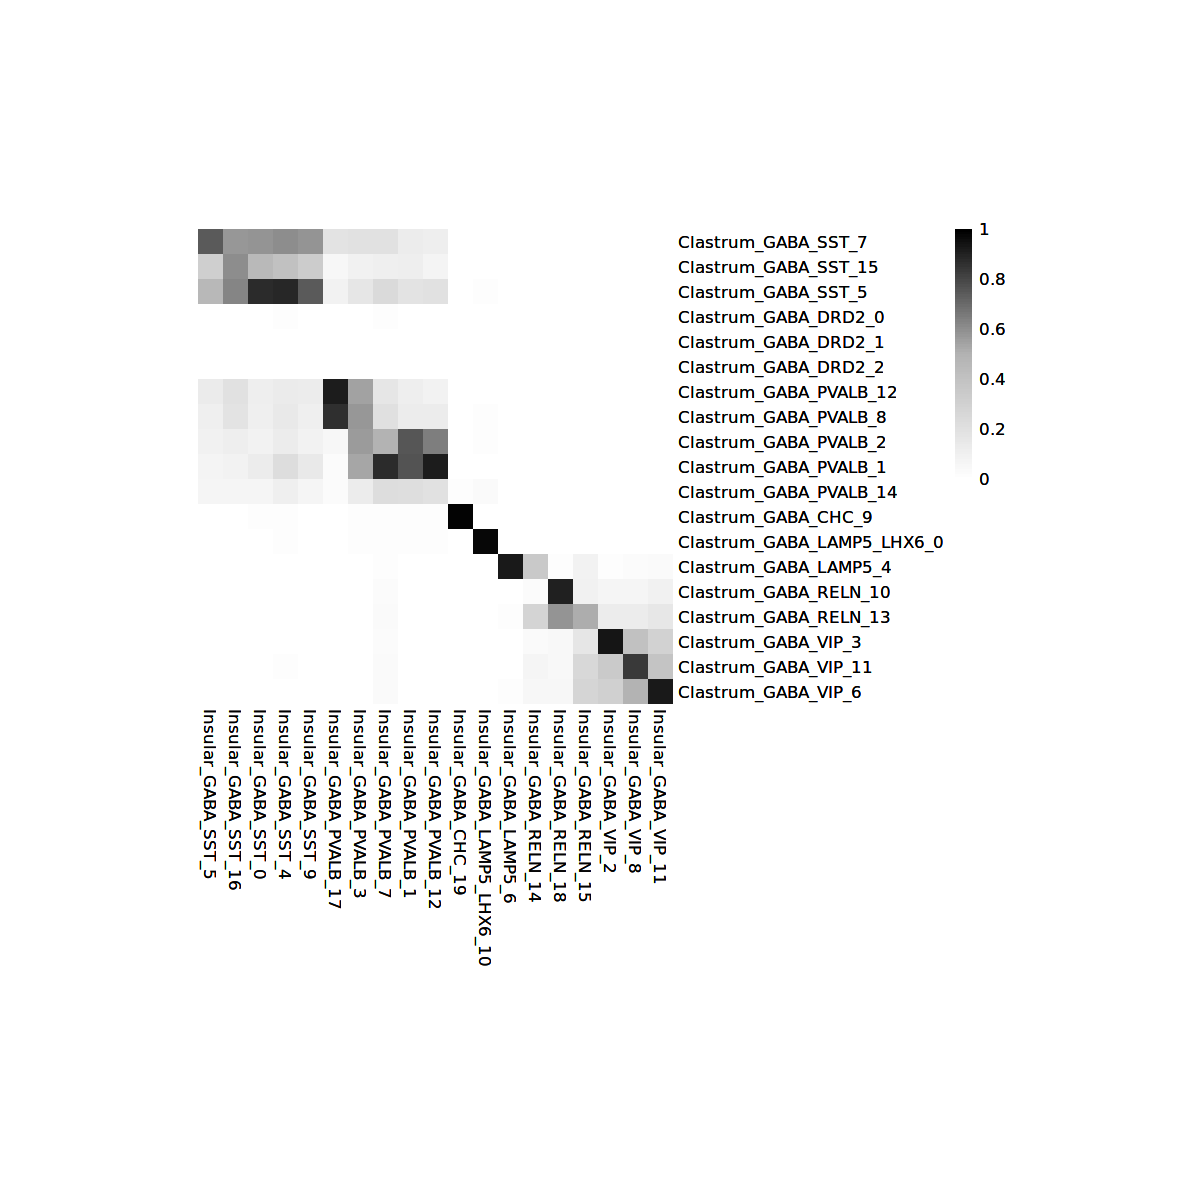

In [130]:
cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)
cocl <- cl.conf$cocl


cocl.subset <- cocl[grepl("Clastrum_GABA", row.names(cocl)),
                    grepl("Insular_GABA", row.names(cocl))]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[ordRow, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
sortedMacaqueCluster = rownames(cocl.subset)
options(repr.plot.width=10, repr.plot.height=10)
order_row=rownames(cocl.subset)
#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))

heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df1=cocl.subset
gp2=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp2

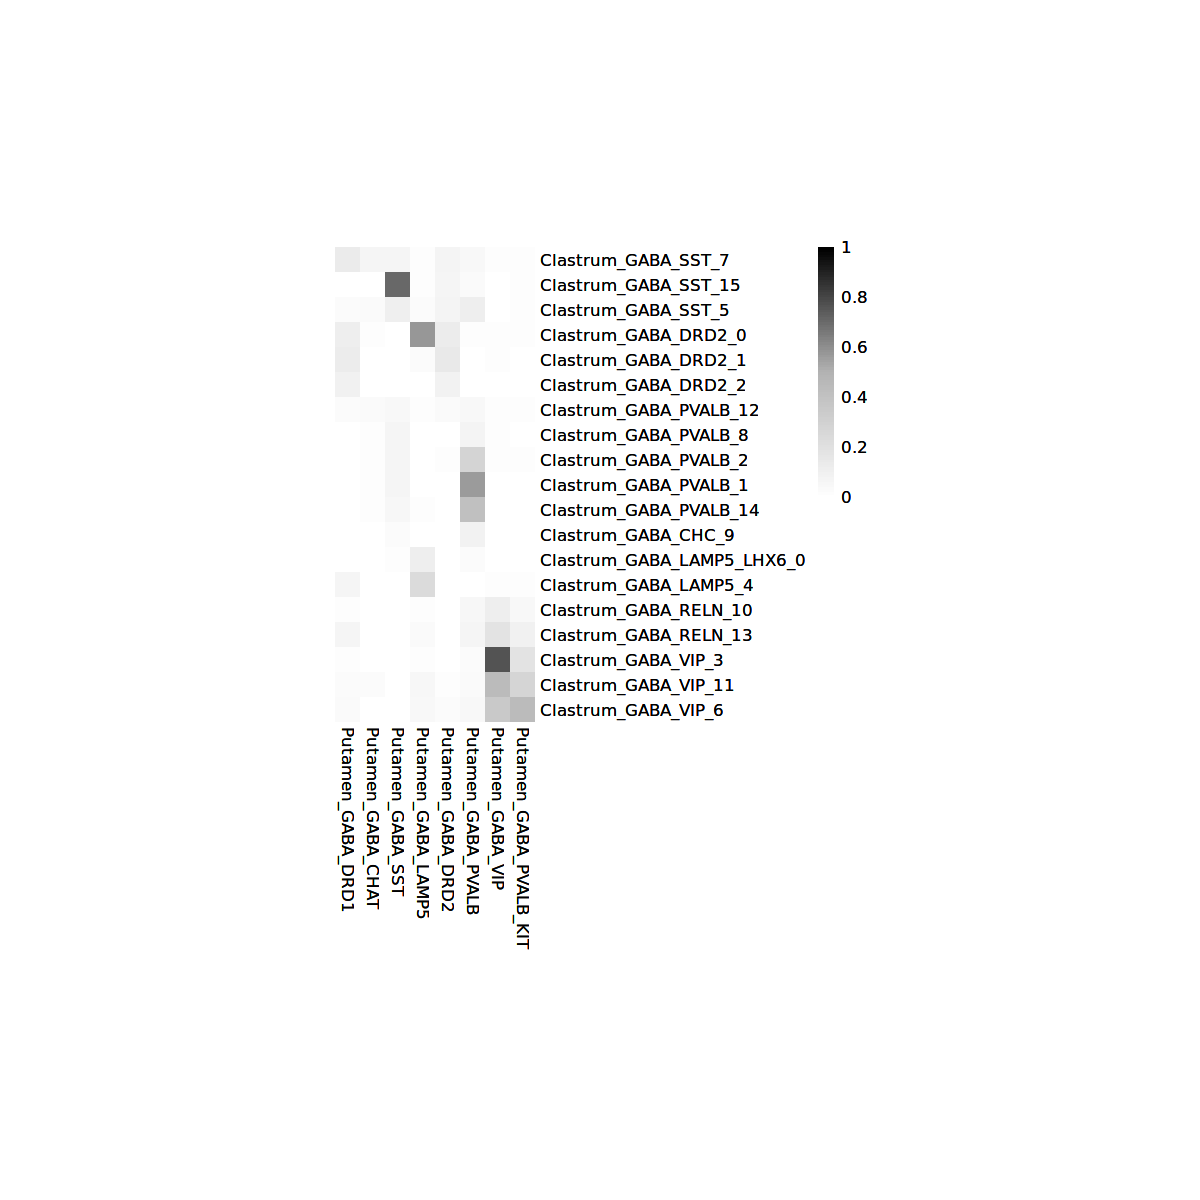

In [131]:
cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)
cocl <- cl.conf$cocl


cocl.subset <- cocl[grepl("Clastrum_GABA", row.names(cocl)),
                    grepl("Putamen_GABA", row.names(cocl))]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[order_row, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
sortedMacaqueCluster = rownames(cocl.subset)
options(repr.plot.width=10, repr.plot.height=10)

#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))

heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df2=cocl.subset
gp2=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp2

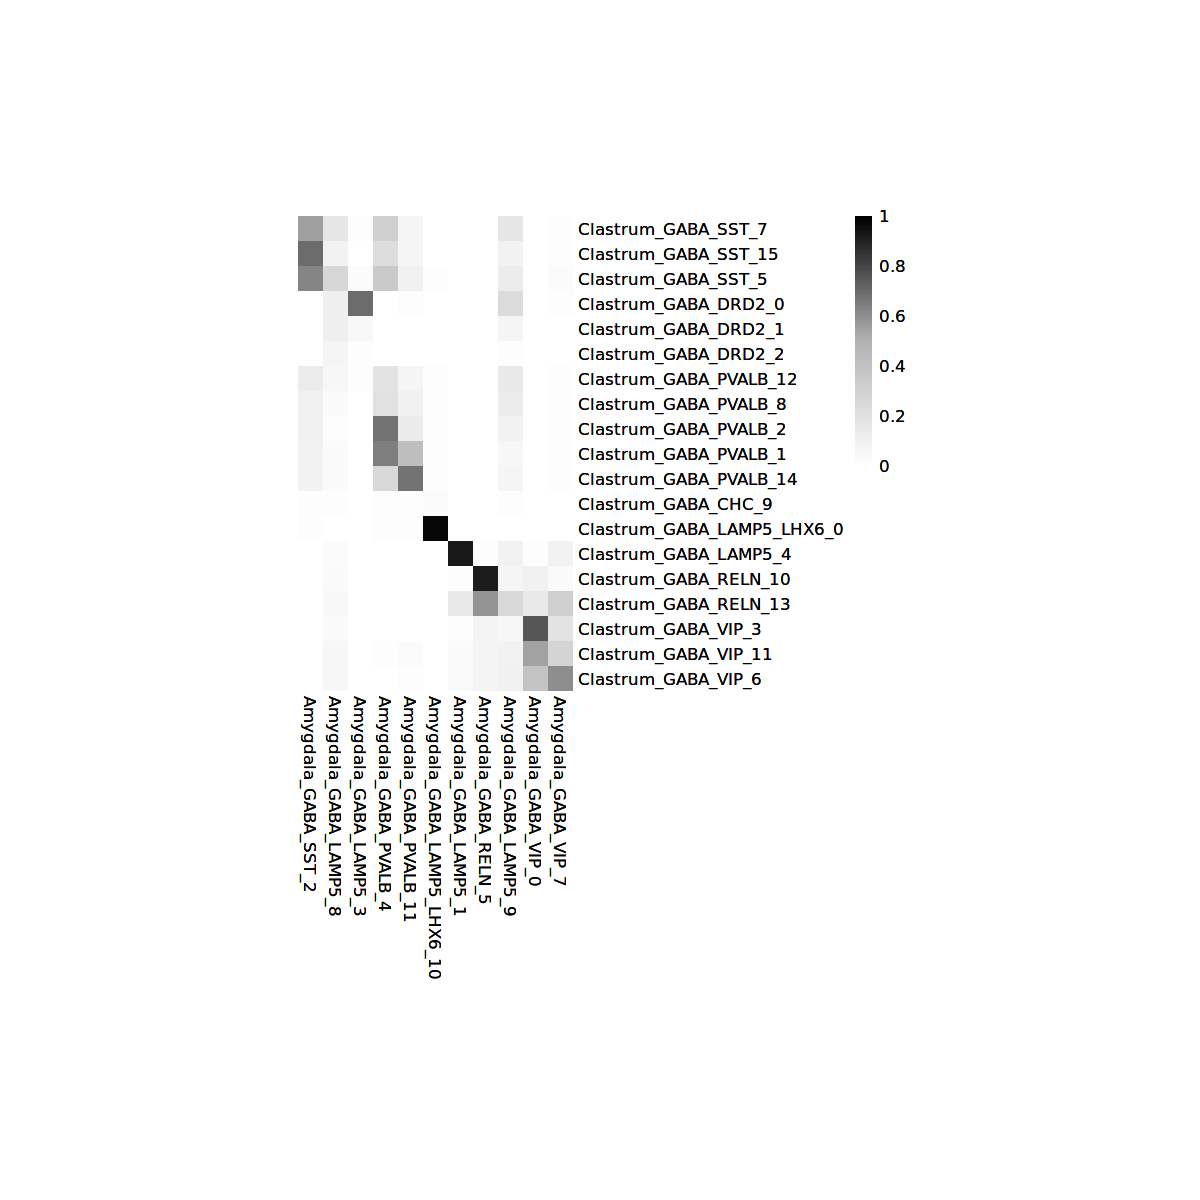

In [132]:
cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)
cocl <- cl.conf$cocl


cocl.subset <- cocl[grepl("Clastrum_GABA", row.names(cocl)),
                    grepl("Amygdala_GABA", row.names(cocl))]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[order_row, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)

options(repr.plot.width=10, repr.plot.height=10)

#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))

heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df3=cocl.subset
gp3=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp3


Joining, by = c("clastrum", "clastrum_insular")
Joining, by = c("clastrum", "clastrum_putamen")
Joining, by = c("clastrum", "clastrum_amygdala")


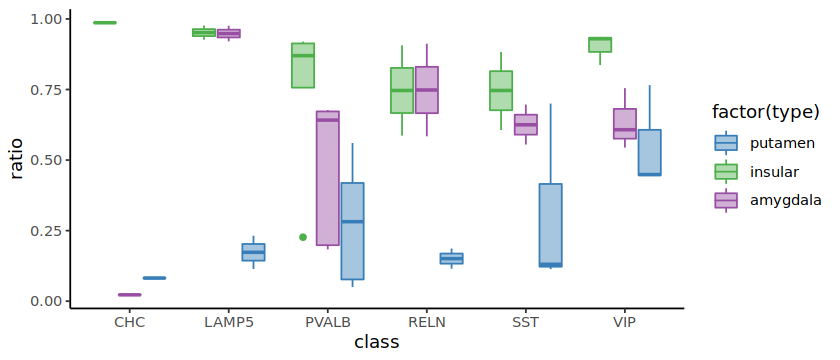

In [133]:
df_clastrum_insular=melt(df1)
df_clastrum_putamen=melt(df2)
df_clastrum_amygdala=melt(df3)

colnames(df_clastrum_insular)=c('clastrum','insular','clastrum_insular')
colnames(df_clastrum_putamen)=c('clastrum','putamen','clastrum_putamen')
colnames(df_clastrum_amygdala)=c('clastrum','amygdala','clastrum_amygdala')

#head(df_clastrum_putamen)
#head(df_clastrum_insular)

#选取与clastrum对照打分最高的
df_com_insular=df_clastrum_insular %>% group_by(clastrum) %>% summarise(insular_clastrum_max=max(clastrum_insular))
colnames(df_com_insular)[2]='clastrum_insular'
df_com_insular=left_join(df_com_insular,df_clastrum_insular)
#head(df_com_insular)

#选取与clastrum对照打分最高的
df_com_putamen=df_clastrum_putamen %>% group_by(clastrum) %>% summarise(putamen_clastrum_max=max(clastrum_putamen))
colnames(df_com_putamen)[2]='clastrum_putamen'
df_com_putamen=left_join(df_com_putamen,df_clastrum_putamen)
#head(df_com_putamen)

#选取与clastrum对照打分最高的
df_com_amygdala=df_clastrum_amygdala %>% group_by(clastrum) %>% summarise(amygdala_clastrum_max=max(clastrum_amygdala))
colnames(df_com_amygdala)[2]='clastrum_amygdala'
df_com_amygdala=left_join(df_com_amygdala,df_clastrum_amygdala)
#head(df_com_amygdala)
clastrum_all_select_type=as.character(unique(df_com_amygdala$clastrum))
df_com_amygdala_new=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[i],][1,]
    df_com_amygdala_new=rbind(df_com_amygdala_new,aba)
}


#renew！！！
clastrum_all_select_type=as.character(unique(df_com_insular$clastrum))
df_com_insular_new=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[i],][1,]
    df_com_insular_new=rbind(df_com_insular_new,aba)
}

clastrum_all_select_type=as.character(unique(df_com_putamen$clastrum))
df_com_putamen_new=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[i],][1,]
    df_com_putamen_new=rbind(df_com_putamen_new,aba)
}

all_n=df_com_insular_new$clastrum
LAMP5=all_n[grep("LAMP5",all_n)]
LAMP5=as.character(LAMP5)
RELN=all_n[grep("RELN",all_n)]
RELN=as.character(RELN)
VIP=all_n[grep("VIP",all_n)]
VIP=as.character(VIP)
SST=all_n[grep("SST",all_n)]
SST=as.character(SST)
PVALB=all_n[grep("PVALB",all_n)]
PVALB=as.character(PVALB)
CHC=all_n[grep("CHC",all_n)]
CHC=as.character(CHC)


df_com_insular_new$cla_class='test'
df_com_insular_new[df_com_insular_new$clastrum %in% LAMP5,]$cla_class='LAMP5'
df_com_insular_new[df_com_insular_new$clastrum %in% RELN,]$cla_class='RELN'
df_com_insular_new[df_com_insular_new$clastrum %in% VIP,]$cla_class='VIP'
df_com_insular_new[df_com_insular_new$clastrum %in% SST,]$cla_class='SST'
df_com_insular_new[df_com_insular_new$clastrum %in% PVALB,]$cla_class='PVALB'
df_com_insular_new[df_com_insular_new$clastrum %in% CHC,]$cla_class='CHC'


df_com_putamen_new$cla_class='test'
df_com_putamen_new[df_com_putamen_new$clastrum %in% LAMP5,]$cla_class='LAMP5'
df_com_putamen_new[df_com_putamen_new$clastrum %in% RELN,]$cla_class='RELN'
df_com_putamen_new[df_com_putamen_new$clastrum %in% VIP,]$cla_class='VIP'
df_com_putamen_new[df_com_putamen_new$clastrum %in% SST,]$cla_class='SST'
df_com_putamen_new[df_com_putamen_new$clastrum %in% PVALB,]$cla_class='PVALB'
df_com_putamen_new[df_com_putamen_new$clastrum %in% CHC,]$cla_class='CHC'


df_com_putamen_new$cla_class='test'
df_com_putamen_new[df_com_putamen_new$clastrum %in% LAMP5,]$cla_class='LAMP5'
df_com_putamen_new[df_com_putamen_new$clastrum %in% RELN,]$cla_class='RELN'
df_com_putamen_new[df_com_putamen_new$clastrum %in% VIP,]$cla_class='VIP'
df_com_putamen_new[df_com_putamen_new$clastrum %in% SST,]$cla_class='SST'
df_com_putamen_new[df_com_putamen_new$clastrum %in% PVALB,]$cla_class='PVALB'
df_com_putamen_new[df_com_putamen_new$clastrum %in% CHC,]$cla_class='CHC'


df_com_amygdala_new$cla_class='test'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% LAMP5,]$cla_class='LAMP5'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% RELN,]$cla_class='RELN'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% VIP,]$cla_class='VIP'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% SST,]$cla_class='SST'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% PVALB,]$cla_class='PVALB'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% CHC,]$cla_class='CHC'



df_putamen=df_com_putamen_new[,c('clastrum_putamen','cla_class')]
colnames(df_putamen)=c('ratio','class')
df_putamen$type='putamen'

df_amygdala=df_com_amygdala_new[,c('clastrum_amygdala','cla_class')]
colnames(df_amygdala)=c('ratio','class')
df_amygdala$type='amygdala'

df_insular=df_com_insular_new[,c('clastrum_insular','cla_class')]
colnames(df_insular)=c('ratio','class')
df_insular$type='insular'
df_all=rbind(rbind(df_putamen,df_insular),df_amygdala)


options(repr.plot.width=7, repr.plot.height=3)

df_all$type=factor(df_all$type,levels=c('insular','amygdala','putamen'))

col_pal=c('#377EB8','#4DAF4A','#984EA3')
names(col_pal)=c('putamen','insular','amygdala')

col_pal_fill=c('#A6C5DF','#AFDBAE','#D1B0D6')
names(col_pal_fill)=c('putamen','insular','amygdala')


#df_all_fil=data.frame(table(df_all$clastrum_layer))
#sel_layer=as.character(df_all_fil[df_all_fil$Freq>=10,]$Var1)
#df_all=df_all[df_all$clastrum_layer %in% sel_layer,]

#df_all$clastrum_layer=factor(df_all$clastrum_layer,levels = c('Upper-layer intratelencephalic','Deep-layer intratelencephalic',
#                         'Deep-layer near-projecting','Deep-layer corticothalamic and 6b'))

df_all=df_all[df_all$class != 'test',]

gp1=ggplot(df_all, aes(x = class, y = ratio, fill = factor(type),color=factor(type))) +  geom_boxplot()+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()
gp1




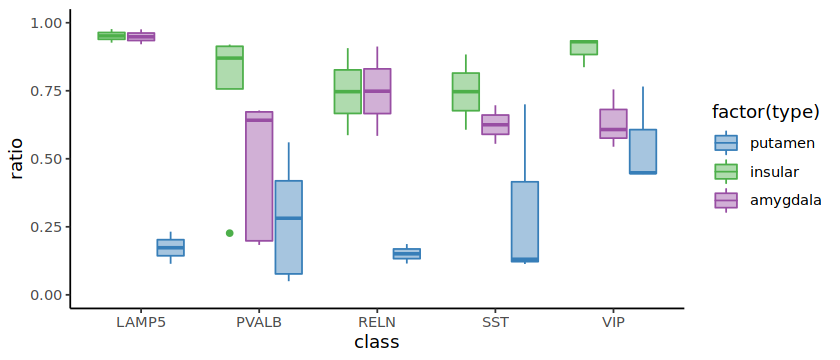

In [134]:
df_all=df_all[df_all$class %in% setdiff(unique(df_all$class),'CHC'),]
gp1=ggplot(df_all, aes(x = class, y = ratio, fill = factor(type),color=factor(type))) +  geom_boxplot()+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()+coord_cartesian(ylim = c(0, 1))
gp1




In [137]:
options(repr.plot.width=5, repr.plot.height=15)
my_comparisons <- list(c(unique(df_all$type)[1], unique(df_all$type)[2]),
                       c(unique(df_all$type)[3], unique(df_all$type)[2]),
                       c(unique(df_all$type)[1], unique(df_all$type)[3]))


df_all1=df_all[df_all$class==unique(df_all$class)[1],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[2],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[3],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[4],]
compare_means(ratio~type, data=df_all1)  

df_all1=df_all[df_all$class==unique(df_all$class)[5],]
compare_means(ratio~type, data=df_all1)  


.y.   group1   group2   p   p.adj p.format p.signif method  
1 ratio insular  amygdala 0.4 0.8   0.4      ns       Wilcoxon
2 ratio insular  putamen  0.2 0.6   0.2      ns       Wilcoxon
3 ratio amygdala putamen  0.7 0.8   0.7      ns       Wilcoxon

.y.   group1   group2   p          p.adj p.format p.signif method  
1 ratio insular  amygdala 0.05555556 0.17  0.056    ns       Wilcoxon
2 ratio insular  putamen  0.05555556 0.17  0.056    ns       Wilcoxon
3 ratio amygdala putamen  0.22222222 0.22  0.222    ns       Wilcoxon

.y.   group1   group2   p         p.adj p.format p.signif method  
1 ratio insular  amygdala 0.6666667 1     0.67     ns       Wilcoxon
2 ratio insular  putamen  0.3333333 1     0.33     ns       Wilcoxon
3 ratio amygdala putamen  0.3333333 1     0.33     ns       Wilcoxon

.y.   group1   group2   p         p.adj p.format p.signif method  
1 ratio insular  amygdala 1.0000000 1     1.00     ns       Wilcoxon
2 ratio insular  putamen  0.3333333 1     0.33     ns       Wilcoxon
3 ratio amygdala putamen  0.3333333 1     0.33     ns       Wilcoxon

.y.   group1   group2   p   p.adj p.format p.signif method  
1 ratio insular  amygdala 0.1 0.3   0.1      ns       Wilcoxon
2 ratio insular  putamen  0.1 0.3   0.1      ns       Wilcoxon
3 ratio amygdala putamen  0.7 0.7   0.7      ns       Wilcoxon

In [113]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat_sort_IN.pdf", width=7, height=3)
gp1
dev.off()


png 
  2

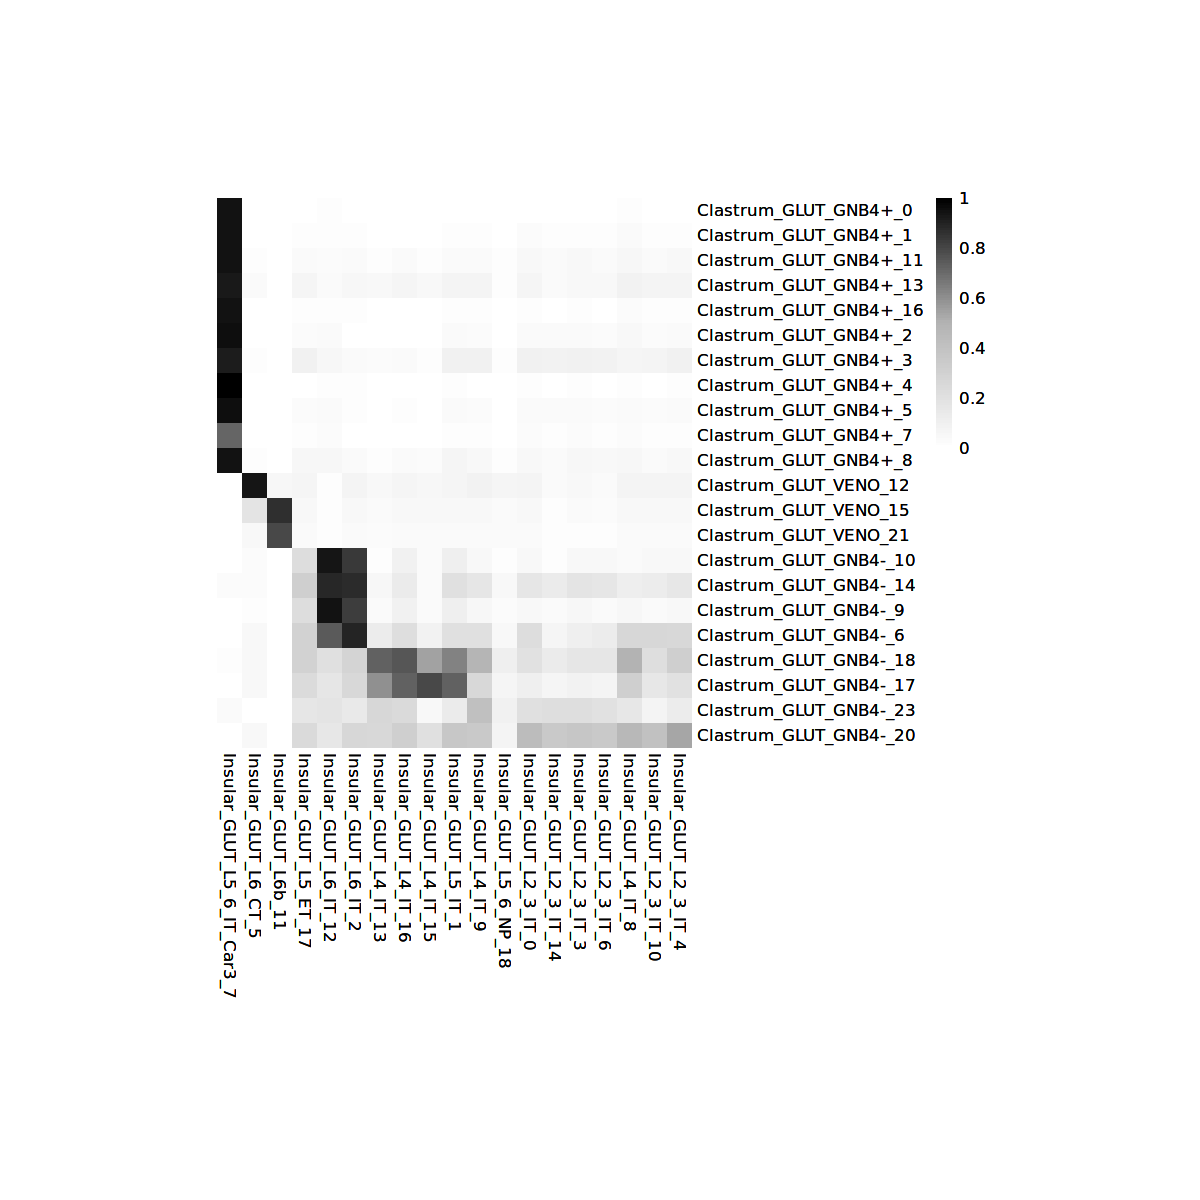

In [47]:
cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)

cocl <- cl.conf$cocl

rownames(cocl)=gsub('__','-_',rownames(cocl))
colnames(cocl)=gsub('__','-_',colnames(cocl))

cocl.subset <- cocl[grepl("Clastrum_GLUT", row.names(cocl)),
                    grepl("Insular_GLUT", row.names(cocl))]

# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=T)
sortedMacaqueCluster = rownames(cocl.subset)

options(repr.plot.width=10, repr.plot.height=10)
order_row=rownames(cocl.subset)
heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df1=cocl.subset
gp1=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp1


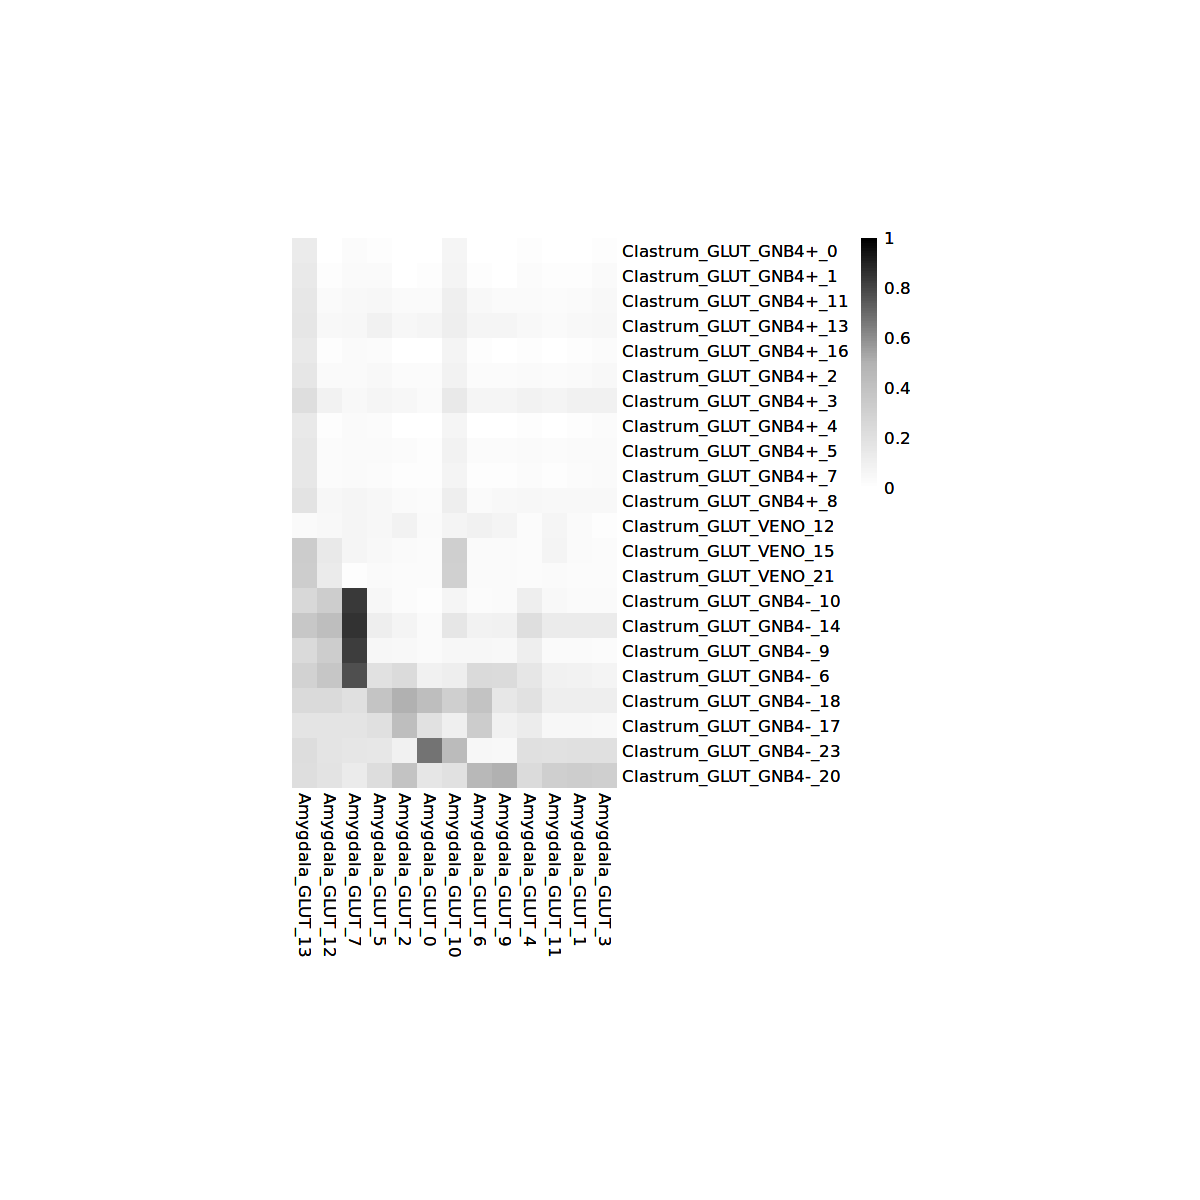

In [48]:
cocl.subset <- cocl[grepl("Clastrum_GLUT", row.names(cocl)),
                    grepl("Amygdala_GLUT", row.names(cocl))]

# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[order_row, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
sortedMacaqueCluster = rownames(cocl.subset)

options(repr.plot.width=10, repr.plot.height=10)



heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df3=cocl.subset
gp1=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp1


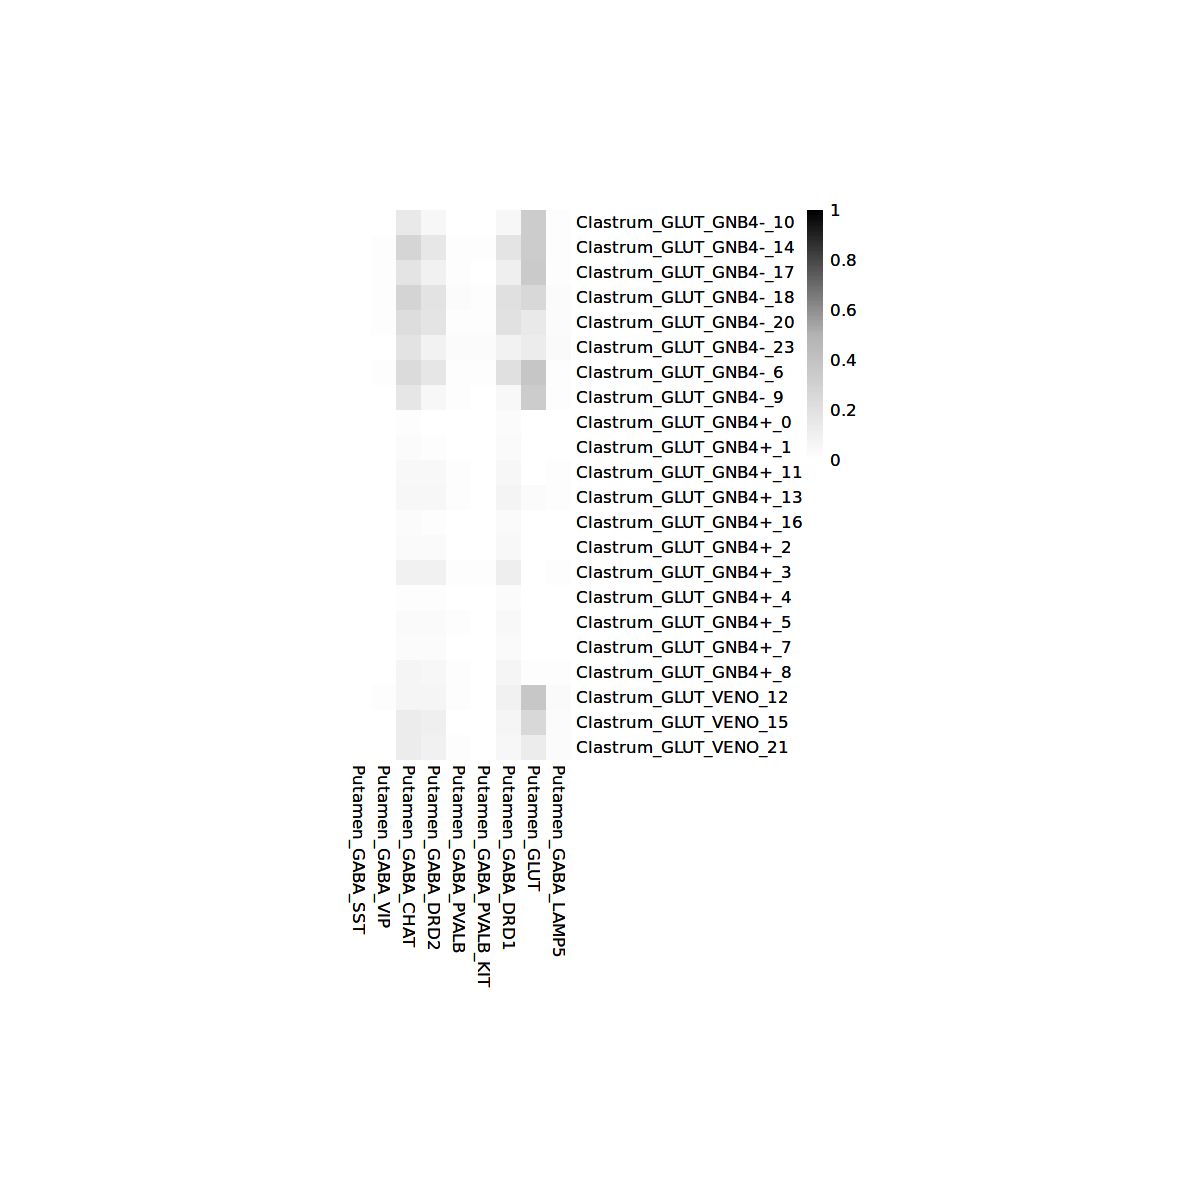

In [49]:

cocl.subset <- cocl[grepl("Clastrum_GLUT", row.names(cocl)),
                    grepl("Putamen_G", row.names(cocl))]

tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset
cocl.subset = reorder_matrix(cocl.subset, by.rows=F)
sortedMacaqueCluster = rownames(cocl.subset)

options(repr.plot.width=10, repr.plot.height=10)

#rownames(df_row)=gsub('Putamen','PU',rownames(df_row))
#rownames(df_row)=gsub('-','_',rownames(df_row))
#rownames(df_col)=gsub('Clastrum','CLA',rownames(df_col))

heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df2=cocl.subset
gp2=pheatmap(cocl.subset, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp2


In [50]:
df_clastrum_insular=melt(df1)
df_clastrum_putamen=melt(df2)
df_clastrum_amygdala=melt(df3)

colnames(df_clastrum_insular)=c('clastrum','insular','clastrum_insular')
colnames(df_clastrum_putamen)=c('clastrum','putamen','clastrum_putamen')
colnames(df_clastrum_amygdala)=c('clastrum','amygdala','clastrum_amygdala')

#head(df_clastrum_putamen)
#head(df_clastrum_insular)

#选取与clastrum对照打分最高的
df_com_insular=df_clastrum_insular %>% group_by(clastrum) %>% summarise(insular_clastrum_max=max(clastrum_insular))
colnames(df_com_insular)[2]='clastrum_insular'
df_com_insular=left_join(df_com_insular,df_clastrum_insular)
#head(df_com_insular)

#选取与clastrum对照打分最高的
df_com_putamen=df_clastrum_putamen %>% group_by(clastrum) %>% summarise(putamen_clastrum_max=max(clastrum_putamen))
colnames(df_com_putamen)[2]='clastrum_putamen'
df_com_putamen=left_join(df_com_putamen,df_clastrum_putamen)
#head(df_com_putamen)

#选取与clastrum对照打分最高的
df_com_amygdala=df_clastrum_amygdala %>% group_by(clastrum) %>% summarise(amygdala_clastrum_max=max(clastrum_amygdala))
colnames(df_com_amygdala)[2]='clastrum_amygdala'
df_com_amygdala=left_join(df_com_amygdala,df_clastrum_amygdala)
#head(df_com_amygdala)
clastrum_all_select_type=as.character(unique(df_com_amygdala$clastrum))
df_com_amygdala_new=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_amygdala[df_com_amygdala$clastrum==clastrum_all_select_type[i],][1,]
    df_com_amygdala_new=rbind(df_com_amygdala_new,aba)
}


#renew！！！
clastrum_all_select_type=as.character(unique(df_com_insular$clastrum))
df_com_insular_new=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_insular[df_com_insular$clastrum==clastrum_all_select_type[i],][1,]
    df_com_insular_new=rbind(df_com_insular_new,aba)
}

clastrum_all_select_type=as.character(unique(df_com_putamen$clastrum))
df_com_putamen_new=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[1],][1,]
for(i in c(2:length(clastrum_all_select_type))){
    aba=df_com_putamen[df_com_putamen$clastrum==clastrum_all_select_type[i],][1,]
    df_com_putamen_new=rbind(df_com_putamen_new,aba)
}


all_n=df_com_insular_new$clastrum
ex_n=all_n[grep("GNB4+",all_n)]
ex_n=as.character(ex_n)
in_n=all_n[grep("GNB4-",all_n)]
in_n=as.character(in_n)
non_n=setdiff(all_n,c(ex_n,in_n))
non_n=as.character(non_n)

df_com_insular_new$cla_class='test'
df_com_insular_new[df_com_insular_new$clastrum %in% ex_n,]$cla_class='GNB4+'
df_com_insular_new[df_com_insular_new$clastrum %in% in_n,]$cla_class='GNB4-'
df_com_insular_new[df_com_insular_new$clastrum %in% non_n,]$cla_class='VENO'

df_com_putamen_new$cla_class='test'
df_com_putamen_new[df_com_putamen_new$clastrum %in% ex_n,]$cla_class='GNB4+'
df_com_putamen_new[df_com_putamen_new$clastrum %in% in_n,]$cla_class='GNB4-'
df_com_putamen_new[df_com_putamen_new$clastrum %in% non_n,]$cla_class='VENO'


df_putamen=df_com_putamen_new[,c('clastrum_putamen','cla_class')]
colnames(df_putamen)=c('ratio','class')
df_putamen$type='puteman'

df_com_amygdala_new$cla_class='test'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% ex_n,]$cla_class='GNB4+'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% in_n,]$cla_class='GNB4-'
df_com_amygdala_new[df_com_amygdala_new$clastrum %in% non_n,]$cla_class='VENO'


df_amygdala=df_com_amygdala_new[,c('clastrum_amygdala','cla_class')]
colnames(df_amygdala)=c('ratio','class')
df_amygdala$type='amygdala'

df_insular=df_com_insular_new[,c('clastrum_insular','cla_class')]
colnames(df_insular)=c('ratio','class')
df_insular$type='insular'

df_all=rbind(rbind(df_putamen,df_insular),df_amygdala)


Joining, by = c("clastrum", "clastrum_insular")
Joining, by = c("clastrum", "clastrum_putamen")
Joining, by = c("clastrum", "clastrum_amygdala")


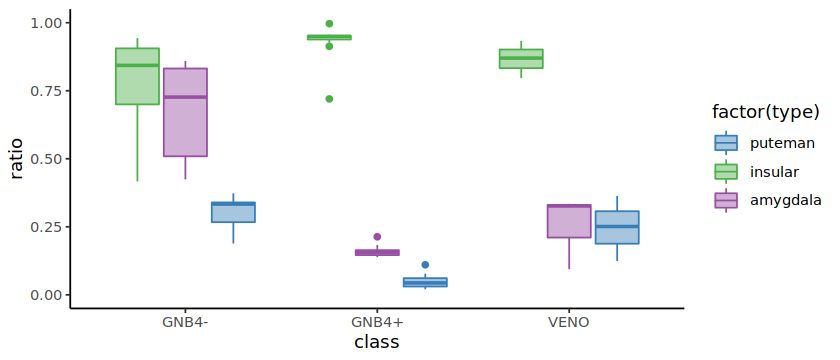

In [51]:

options(repr.plot.width=7, repr.plot.height=3)

df_all$type=factor(df_all$type,levels=c('insular','amygdala','puteman'))

col_pal=c('#377EB8','#4DAF4A','#984EA3')
names(col_pal)=c('puteman','insular','amygdala')

col_pal_fill=c('#A6C5DF','#AFDBAE','#D1B0D6')
names(col_pal_fill)=c('puteman','insular','amygdala')

#df_all_fil=data.frame(table(df_all$clastrum_layer))
#sel_layer=as.character(df_all_fil[df_all_fil$Freq>=10,]$Var1)
#df_all=df_all[df_all$clastrum_layer %in% sel_layer,]

#df_all$clastrum_layer=factor(df_all$clastrum_layer,levels = c('Upper-layer intratelencephalic','Deep-layer intratelencephalic',
#                         'Deep-layer near-projecting','Deep-layer corticothalamic and 6b'))



gp1=ggplot(df_all, aes(x = class, y = ratio, fill = factor(type),color=factor(type))) +  geom_boxplot()+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()+coord_cartesian(ylim = c(0, 1))
gp1




In [53]:
df_all1=df_all[df_all$class=='GNB4-',]
compare_means(ratio~type, data=df_all1)  
df_all1=df_all[df_all$class=='GNB4+',]
compare_means(ratio~type, data=df_all1)  
df_all1=df_all[df_all$class=='VENO',]
compare_means(ratio~type, data=df_all1)  

.y.   group1   group2   p            p.adj  p.format p.signif method  
1 ratio insular  amygdala 0.2344988345 0.2300 0.23450  ns       Wilcoxon
2 ratio insular  puteman  0.0009309723 0.0028 0.00093  ***      Wilcoxon
3 ratio amygdala puteman  0.0009309723 0.0028 0.00093  ***      Wilcoxon

.y.   group1   group2   p             p.adj   p.format p.signif method  
1 ratio insular  amygdala 0.00007743803 0.00023 0.000077 ****     Wilcoxon
2 ratio insular  puteman  0.00007780212 0.00023 0.000078 ****     Wilcoxon
3 ratio amygdala puteman  0.00008113807 0.00023 0.000081 ****     Wilcoxon

.y.   group1   group2   p   p.adj p.format p.signif method  
1 ratio insular  amygdala 0.1 0.3   0.1      ns       Wilcoxon
2 ratio insular  puteman  0.1 0.3   0.1      ns       Wilcoxon
3 ratio amygdala puteman  1.0 1.0   1.0      ns       Wilcoxon

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message in wilcox.test.default(c(0.8375, 0.859166666666667, 0.83, 0.774166666666667, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.336666666666667, 0.333333333333333, 0.347777777777778, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.95, 0.95

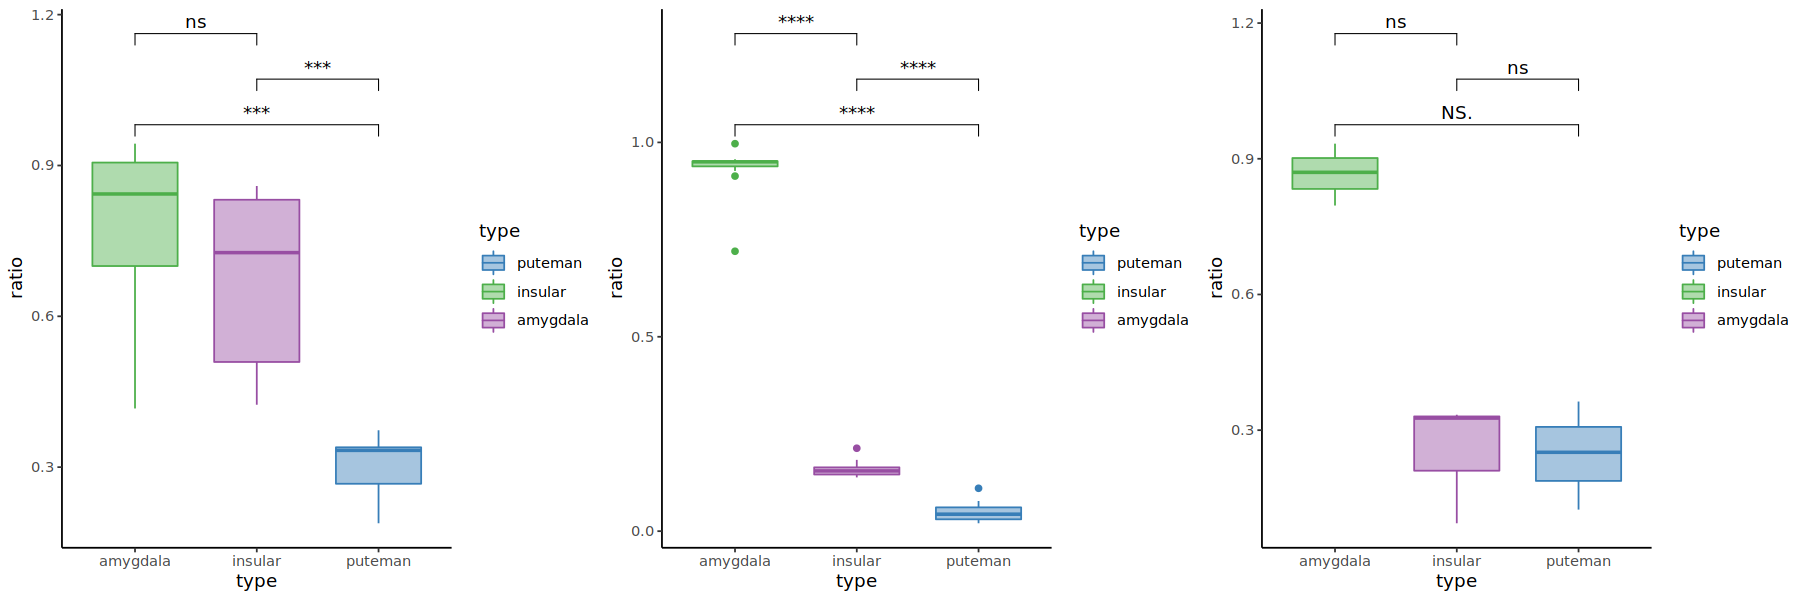

In [52]:
options(repr.plot.width=5, repr.plot.height=5)
df_all1=df_all[df_all$class==unique(df_all$class)[1],]
my_comparisons <- list(c("amygdala", "puteman"), c("puteman", "insular"), c("insular", "amygdala"))
p1=ggboxplot(df_all1, x="type", y="ratio", palette = "jco",color = "type",fill="type")+
stat_compare_means(comparisons=my_comparisons,label = "p.signif",)+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()
df_all1=df_all[df_all$class==unique(df_all$class)[2],]
p2=ggboxplot(df_all1, x="type", y="ratio", palette = "jco",color = "type",fill="type")+
stat_compare_means(comparisons=my_comparisons,label = "p.signif",)+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()
df_all1=df_all[df_all$class==unique(df_all$class)[3],]
p3=ggboxplot(df_all1, x="type", y="ratio", palette = "jco",color = "type",fill="type")+
stat_compare_means(comparisons=my_comparisons,label = "p.signif",)+
scale_color_manual(values = col_pal)+
scale_fill_manual(values = col_pal_fill)+
theme_classic()

options(repr.plot.width=15, repr.plot.height=5)
gp1=plot_grid(p1,p2,p3,nrow=1)
gp1

In [119]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat_sort_EX.pdf", width=7, height=3)
gp1
dev.off()


png 
  2

In [129]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/heat_sort_EX.pdf", width=15, height=5)
gp1
dev.off()



png 
  2